# 載入套件

In [123]:
# 安裝兼容版本
!pip install tensorflow==2.15.0 -q
!pip install keras==2.15.0 -q
!pip install scikeras==0.12.0 -q

# 安裝所需的其他包
!pip install scikeras -q
!pip install keras -q
!pip install scikeras -q
!pip install prophet -q
!pip install xgboost -q
!pip install catboost -q
!pip install lightgbm -q

In [124]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from sklearn.ensemble import BaggingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.utils.validation import has_fit_parameter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 合併 2 個資料集
>　主表　c591_final_detailed_usage_full_main_data_for_xgb_v2

>　經濟　final_eco_df_to_11306_fillna_v2

>　合併後的『主表』名稱是 `df`

In [313]:
# 591 + 經濟指標 = df

onehot_591_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_final_detailed_usage_full_main_data_for_xgb_v2.csv')

economic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_eco_df_to_11306_fillna_v2.csv')

In [314]:
onehot_591_df.head(2)

,community_name,main_building_ratio,building_age,total_area_ping,total_floors,target_floor,transaction_floors,bedrooms,living_rooms,bathrooms,...,district__石門區,district__萬華區,district__萬里區,district__蘆洲區,district__貢寮區,district__金山區,district__雙溪區,district__鶯歌區,usage_category__住商用,usage_category__住家用
0,0,100.0,41.0,20.81,4.0,4.0,1.0,2.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0,86.1,38.0,32.31,5.0,4.0,1.0,3.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [315]:
economic_df.head(2)

,date,house_index_xyi_all_tp,house_index_xyi_tp,house_index_xyi_new_tp,EB18,EB21,MC31,MC31G,MC36,NA0101,...,PA0120,PA1205,PE0503,TSE收盤,水泥(TSE11)收盤,建材營造(TSE25)收盤,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,預拌混凝土3000磅台北,year_month_for_combine
0,2011-01,95.40,94.45,96.84,86.78,95.85,5138597.0,6.2279,1259098.0,3552329.0,...,90.25,23911.0,83.35,8970.758500,109.81,347.10,123.49,120.70,1815.0,2011-01
1,2011-02,97.69,97.34,98.23,85.89,96.75,5133940.0,5.9953,1270638.0,3552329.0,...,90.93,23911.0,83.71,8742.564286,102.64,311.73,108.61,117.89,1890.0,2011-02


In [316]:
onehot_591_df.info(max_cols=97)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 97 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   community_name                        669734 non-null  int64  
 1   main_building_ratio                   669734 non-null  float64
 2   building_age                          669734 non-null  float64
 3   total_area_ping                       669734 non-null  float64
 4   total_floors                          669734 non-null  float64
 5   target_floor                          669734 non-null  float64
 6   transaction_floors                    669734 non-null  float64
 7   bedrooms                              669734 non-null  float64
 8   living_rooms                          669734 non-null  float64
 9   bathrooms                             669734 non-null  float64
 10  year_month_for_combine                669734 non-null  object 
 11  

In [317]:
economic_df.info(max_cols=25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    162 non-null    object 
 1   house_index_xyi_all_tp  162 non-null    float64
 2   house_index_xyi_tp      162 non-null    float64
 3   house_index_xyi_new_tp  162 non-null    float64
 4   EB18                    162 non-null    float64
 5   EB21                    162 non-null    float64
 6   MC31                    162 non-null    float64
 7   MC31G                   162 non-null    float64
 8   MC36                    162 non-null    float64
 9   NA0101                  162 non-null    float64
 10  NA1005                  162 non-null    float64
 11  NB0101                  162 non-null    float64
 12  NC0117                  162 non-null    float64
 13  NC0118                  162 non-null    float64
 14  NE0206                  162 non-null    fl

In [318]:
# 確認日期欄位格式一致
onehot_591_df['year_month_for_combine'] = pd.to_datetime(onehot_591_df['year_month_for_combine'])
economic_df['year_month_for_combine'] = pd.to_datetime(economic_df['year_month_for_combine'])

# 合併兩個資料表
df = pd.merge(onehot_591_df, economic_df, on='year_month_for_combine')

# 刪除 date欄位
df = df.drop('date', axis=1)

# # 儲存合併後的資料表
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/df.csv', index=False)

# print("資料表已成功合併並儲存為 df.csv")

In [319]:
df.head(2)

,community_name,main_building_ratio,building_age,total_area_ping,total_floors,target_floor,transaction_floors,bedrooms,living_rooms,bathrooms,...,NE0206,PA0120,PA1205,PE0503,TSE收盤,水泥(TSE11)收盤,建材營造(TSE25)收盤,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,預拌混凝土3000磅台北
0,0,100.0,41.0,20.81,4.0,4.0,1.0,2.0,1.0,1.0,...,194796.0,96.18,20265.0,82.68,9245.263182,111.78,240.09,57.3,98.06,1750.0
1,0,86.1,38.0,32.31,5.0,4.0,1.0,3.0,2.0,2.0,...,194796.0,96.18,20265.0,82.68,9245.263182,111.78,240.09,57.3,98.06,1750.0


In [320]:
df.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 120 columns):
 #    Column                                Non-Null Count   Dtype         
---   ------                                --------------   -----         
 0    community_name                        669734 non-null  int64         
 1    main_building_ratio                   669734 non-null  float64       
 2    building_age                          669734 non-null  float64       
 3    total_area_ping                       669734 non-null  float64       
 4    total_floors                          669734 non-null  float64       
 5    target_floor                          669734 non-null  float64       
 6    transaction_floors                    669734 non-null  float64       
 7    bedrooms                              669734 non-null  float64       
 8    living_rooms                          669734 non-null  float64       
 9    bathrooms                             669734 n

In [321]:
df.describe()

,community_name,main_building_ratio,building_age,total_area_ping,total_floors,target_floor,transaction_floors,bedrooms,living_rooms,bathrooms,...,NE0206,PA0120,PA1205,PE0503,TSE收盤,水泥(TSE11)收盤,建材營造(TSE25)收盤,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,預拌混凝土3000磅台北
count,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,...,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000,669734.000000
mean,0.664208,65.438193,20.436672,39.904747,11.882570,6.822621,1.064600,2.790141,1.768801,1.715917,...,201813.953582,97.929671,24072.182490,90.830847,11610.337389,148.103873,309.250287,102.529112,112.459465,1989.921740
min,0.000000,0.630000,1.000000,5.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,...,157387.000000,92.500000,16877.000000,80.580000,7187.136364,97.560000,210.980000,49.250000,72.320000,1680.000000
25%,0.000000,48.620000,12.000000,26.110000,5.000000,3.000000,1.000000,2.000000,2.000000,1.000000,...,179835.000000,94.780000,22093.000000,84.200000,8899.740000,127.310000,270.510000,65.380000,97.590000,1831.250000
50%,1.000000,59.130000,17.000000,35.280000,12.000000,5.000000,1.000000,3.000000,2.000000,2.000000,...,194996.000000,97.500000,22915.000000,87.370000,10574.494091,150.810000,299.870000,74.880000,101.300000,1956.250000
75%,1.000000,83.360000,32.000000,49.010000,15.000000,10.000000,1.000000,3.000000,2.000000,2.000000,...,227118.000000,99.290000,24479.000000,95.660000,14512.766364,164.160000,346.900000,113.970000,123.400000,2100.000000
max,1.000000,100.000000,113.000000,150.450000,46.000000,45.000000,23.000000,62.000000,60.000000,60.000000,...,268641.000000,107.390000,32179.000000,110.430000,23032.250000,205.630000,607.750000,366.570000,205.410000,2800.000000
std,0.472267,20.031322,13.624001,20.456295,7.153746,5.256752,0.362148,1.029130,0.570605,0.807155,...,30070.456290,3.714067,3871.154396,9.276009,3432.489833,24.338274,55.160429,61.224857,27.442586,247.198238


In [322]:
df.isnull().sum().sum()

0

# 分割資料集

> 提取 2024-03-31 以前的資料，作為 train_idx ( 訓練集 )

> 提取 2024-03-31 後的資料，作為 test_idx ( 測試集 )





In [296]:
# 確保日期欄位轉換為日期格式
df['year_month_for_combine'] = pd.to_datetime(df['year_month_for_combine'])

df.set_index('year_month_for_combine', inplace=True)

In [297]:
# 分割資料為訓練集、測試集
# 提取 2024-03-31 以前的資料
train_df = df[df.index <= '2024-03-31']

# 提取 2024-03-31 後的資料作為測試集
test_df = df[df.index > '2024-03-31']

In [298]:
# 確認分割結果
print(f"訓練和測試集數據量: {train_df.shape}")
print(f"驗證集數據量: {test_df.shape}")

訓練和測試集數據量: (664436, 119)
驗證集數據量: (5298, 119)


In [299]:
df.shape

(669734, 119)

In [300]:
# 切割資料為訓練、測試

# 保留 year_month_for_combine 用來畫圖
X_train = train_df.drop(['new_per_ping'], axis=1)
y_train = train_df['new_per_ping']

X_test = test_df.drop(['new_per_ping'], axis=1)
y_test = test_df['new_per_ping']

# 標準化 / 正則化

**以下是 one-hot encoding 的欄位 ：**

> DA 列至 BA 列： 第 47 列至第 97 列。

> A 列是第 1 列。

In [301]:
# 確定 one-hot encoding 的欄位範圍
one_hot_cols = list(range(47, 97)) + [0]

# 取出 one-hot encoding 的欄位
X_train_one_hot = X_train.iloc[:, one_hot_cols]
X_test_one_hot = X_test.iloc[:, one_hot_cols]

# 取出非 one-hot encoding 的欄位，即連續型變數
continuos_col_name = X_train.drop(columns=X_train_one_hot.columns).select_dtypes(include=['number']).columns
X_train_continuos = X_train[continuos_col_name]
X_test_continuos = X_test[continuos_col_name]

# 標準化連續型變數
scaler = StandardScaler()
X_train_continuos_scaled = scaler.fit_transform(X_train_continuos)
X_test_continuos_scaled = scaler.transform(X_test_continuos)

# 合併標準化後的連續型變數與 one-hot encoding 的欄位
X_train_final = np.hstack([X_train_continuos_scaled, X_train_one_hot])
X_test_final = np.hstack([X_test_continuos_scaled, X_test_one_hot])


In [302]:
X_train_final.shape

(664436, 118)

In [303]:
X_test_final.shape

(5298, 118)

# 單棵樹

> 先執行 Bagging Regressor 的 初始化模型再做

Evaluating XGBoost
--------------------------------------------------
XGBoost model Mean MSE (Train): 1802125119.5815895
XGBoost model MAE (Train): 27346.625951650978
XGBoost model RMSE (Train): 42451.44425789998
XGBoost model Mean R² (Train): 0.9540078929046295
--------------------------------------------------
XGBoost model Mean MSE (Test): 10488192680.907164
XGBoost model MAE (Test): 66601.05280486151
XGBoost model RMSE (Test): 102411.87763588344
XGBoost model Mean R² (Test): 0.8003243877534104
--------------------------------------------------
XGBoost model 模型已保存為 XGBoost_one_model_training.pkl


<ipython-input-36-c8c2f3770020>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-36-c8c2f3770020>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


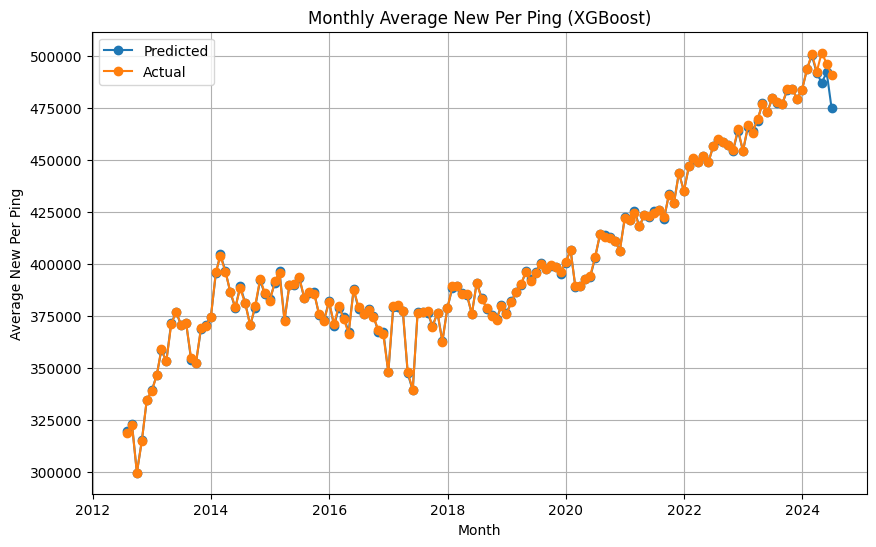

Evaluating CatBoost
--------------------------------------------------
CatBoost model Mean MSE (Train): 11112077722.393066
CatBoost model MAE (Train): 71318.70718624674
CatBoost model RMSE (Train): 105413.8402791259
CatBoost model Mean R² (Train): 0.7164082209902052
--------------------------------------------------
CatBoost model Mean MSE (Test): 17383183935.42926
CatBoost model MAE (Test): 95563.76773442497
CatBoost model RMSE (Test): 131845.30304652214
CatBoost model Mean R² (Test): 0.6690566238909239
--------------------------------------------------
CatBoost model 模型已保存為 CatBoost_one_model_training.pkl


<ipython-input-36-c8c2f3770020>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-36-c8c2f3770020>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


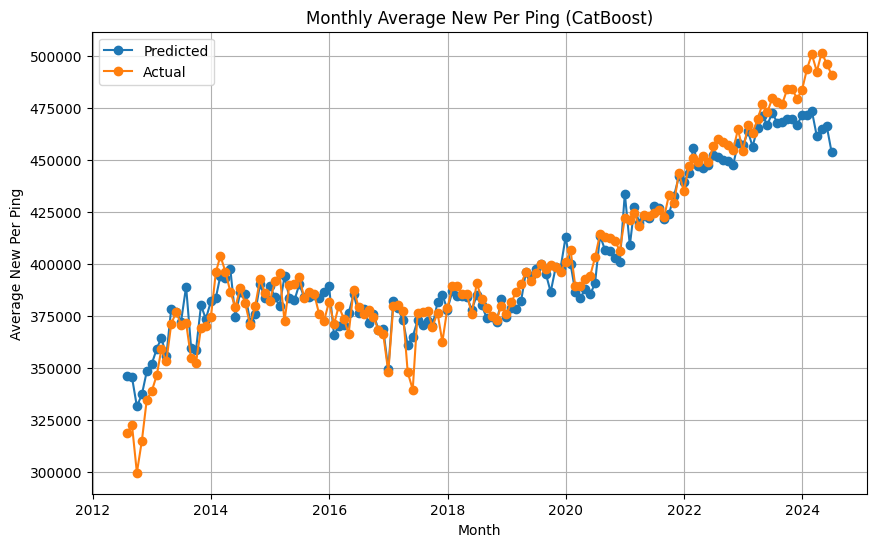

Evaluating LightGBM
--------------------------------------------------
LightGBM model Mean MSE (Train): 9211140424.817068
LightGBM model MAE (Train): 63756.83812407657
LightGBM model RMSE (Train): 95974.68637519515
LightGBM model Mean R² (Train): 0.76492211762353
--------------------------------------------------
LightGBM model Mean MSE (Test): 14408820809.422554
LightGBM model MAE (Test): 86323.77980966843
LightGBM model RMSE (Test): 120036.7477459405
LightGBM model Mean R² (Test): 0.7256829461084997
--------------------------------------------------
LightGBM model 模型已保存為 LightGBM_one_model_training.pkl


<ipython-input-36-c8c2f3770020>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-36-c8c2f3770020>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


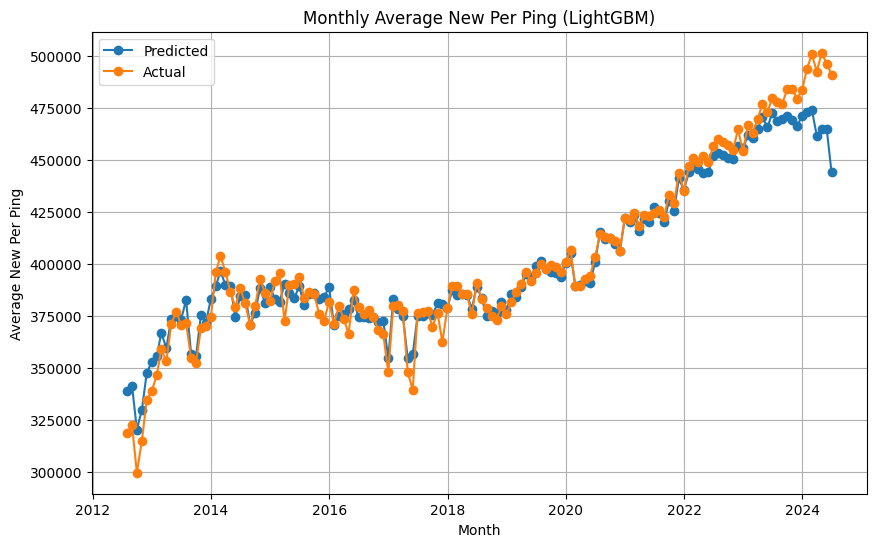

In [36]:
import joblib

# 訓練和評估所有模型，並使用 Bagging Regressor
for name, model in models.items():
    print(f"Evaluating {name}")
    print("-" * 50)

    # 預測訓練集和測試集
    model = model.fit(X_train_final, y_train)

    y_pred_train = model.predict(X_train_final)
    y_pred_test = model.predict(X_test_final)

    # 計算均方誤差
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # 計算 mae
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # 計算R²
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # 計算RMSE
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # 輸出評估結果
    print(f"{name} model Mean MSE (Train): {mse_train}")
    print(f"{name} model MAE (Train): {mae_train}")
    print(f"{name} model RMSE (Train): {rmse_train}")
    print(f"{name} model Mean R² (Train): {r2_train}")
    print("-" * 50)
    print(f"{name} model Mean MSE (Test): {mse_test}")
    print(f"{name} model MAE (Test): {mae_test}")
    print(f"{name} model RMSE (Test): {rmse_test}")
    print(f"{name} model Mean R² (Test): {r2_test}")
    print("-" * 50)

    # 保存模型
    model_filename = f"{name}_one_model_training.pkl"
    joblib.dump(model, model_filename)
    print(f"{name} model 模型已保存為 {model_filename}")
    print("=" * 50)

    # 合併測試集和驗證集的預測結果與日期欄位
    test_results = pd.DataFrame({
        'date': X_test.index,
        'predicted_new_per_ping': y_pred_test
    })
    train_results = pd.DataFrame({
        'date': X_train.index,
        'predicted_new_per_ping': y_pred_train
    })

    # 合併所有結果
    combined_results = pd.concat([train_results, test_results])

    # 繪製每個月的預測房價
    combined_results['date'] = pd.to_datetime(combined_results['date'])
    combined_results.set_index('date', inplace=True)

    # 按月份分組並計算平均預測房價
    monthly_avg_predicted_prices = combined_results.resample('M').mean()

    # 繪製結果
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_avg_predicted_prices.index, monthly_avg_predicted_prices['predicted_new_per_ping'], marker='o', label='Predicted')

    # 繪製實際值
    train_df['date'] = train_df.index
    test_df['date'] = test_df.index

    combined_actual = pd.concat([train_df[['date', 'new_per_ping']], test_df[['date', 'new_per_ping']]])
    combined_actual.set_index('date', inplace=True)
    monthly_avg_actual_prices = combined_actual.resample('M').mean()

    plt.plot(monthly_avg_actual_prices.index, monthly_avg_actual_prices['new_per_ping'], marker='o', label='Actual')

    plt.xlabel('Month')
    plt.ylabel('Average New Per Ping')
    plt.title(f'Monthly Average New Per Ping ({name})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Bagging Regressor

## 初始化模型

> 使用 optuna 和 GridSearchCV 找出超參數

> 套用超參數

In [154]:
# 初始化各種模型
models = {
    "XGBoost": xgb.XGBRegressor(n_estimators=79, max_depth=13, learning_rate=0.23868392277107967, reg_alpha=0.1, reg_lambda=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=60, depth=2, learning_rate=0.29042538244092253, loss_function='RMSE', random_seed=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=70, max_depth=5, learning_rate=0.07717356617261285, random_state=42, verbose=-1),
  }

# KNN ,XGBoost, RandomForestRegressor 使用 optuna 的結果 # 已執行
# XGBoost: n_estimators: 79, max_depth: 13, learning_rate: 0.23868392277107967
# LightGBM: n_estimators=70, max_depth=5, learning_rate=0.07717356617261285
# MLP: hidden_layer_sizes=65, alpha=2.257104482357874e-05
# KNN: n_neighbors: 5，結果為 -18469279756.85388。
# RandomForest: n_estimators=51, max_depth=8，結果為 -12081378969.187416。
# CatBoost: iterations=60, depth=2, learning_rate=0.29042538244092253 ，結果為 -12323696473.352594。
# "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=10),
# "RandomForestRegressor": RandomForestRegressor(n_estimators=51, max_depth=8),
# "MLPRegressor": MLPRegressor(hidden_layer_sizes=(65,), max_iter=500, learning_rate_init=0.01, alpha=2.257104482357874e-05, random_state=42),
# "XGBoost": xgb.XGBRegressor(n_estimators=79, max_depth=13, learning_rate=0.23868392277107967, reg_alpha=0.1, reg_lambda=0.1, random_state=42),
# "CatBoost": CatBoostRegressor(iterations=60, depth=2, learning_rate=0.29042538244092253, loss_function='RMSE', random_seed=42, verbose=0),
# "LightGBM": LGBMRegressor(n_estimators=70, max_depth=5, learning_rate=0.07717356617261285, random_state=42),

## 訓練模型

Evaluating XGBoost with Bagging Regressor
--------------------------------------------------
XGBoost Bagging Regressor Mean MSE (Train): 2282459157.0882735
XGBoost Bagging Regressor MAE (Train): 29257.67162461742
XGBoost Bagging Regressor RMSE (Train): 47775.08929440398
XGBoost Bagging Regressor Mean R² (Train): 0.9417492687644321
--------------------------------------------------
XGBoost Bagging Regressor Mean MSE (Test): 9484287350.371778
XGBoost Bagging Regressor MAE (Test): 63670.788323188
XGBoost Bagging Regressor RMSE (Test): 97387.30589954616
XGBoost Bagging Regressor Mean R² (Test): 0.8194368714396779
--------------------------------------------------
XGBoost Bagging Regressor 模型已保存為 XGBoost_bagging_model_training.pkl


<ipython-input-31-ff1fe2d91444>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-31-ff1fe2d91444>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


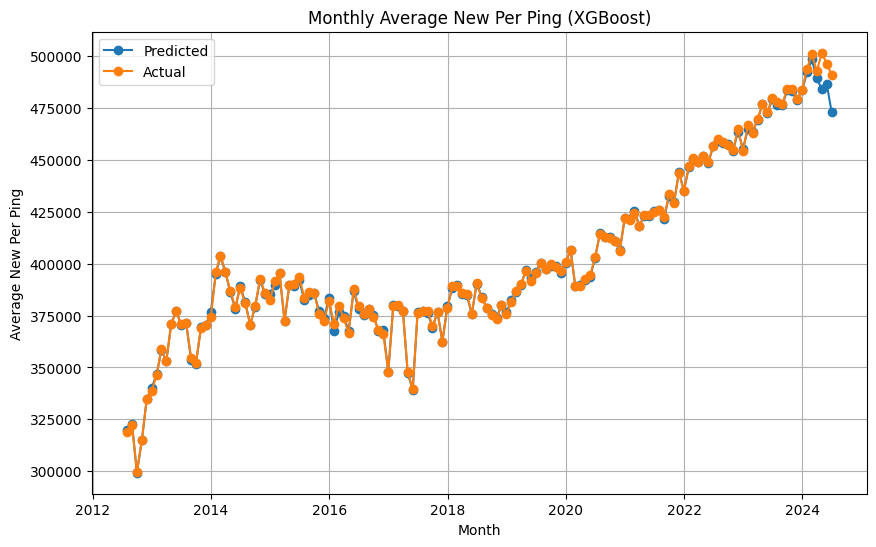

Evaluating CatBoost with Bagging Regressor
--------------------------------------------------
CatBoost Bagging Regressor Mean MSE (Train): 11013143723.00405
CatBoost Bagging Regressor MAE (Train): 70969.269498592
CatBoost Bagging Regressor RMSE (Train): 104943.52635110014
CatBoost Bagging Regressor Mean R² (Train): 0.7189331195368329
--------------------------------------------------
CatBoost Bagging Regressor Mean MSE (Test): 17516724579.745327
CatBoost Bagging Regressor MAE (Test): 96323.07550047703
CatBoost Bagging Regressor RMSE (Test): 132350.76342713452
CatBoost Bagging Regressor Mean R² (Test): 0.66651425927913
--------------------------------------------------
CatBoost Bagging Regressor 模型已保存為 CatBoost_bagging_model_training.pkl


<ipython-input-31-ff1fe2d91444>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-31-ff1fe2d91444>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


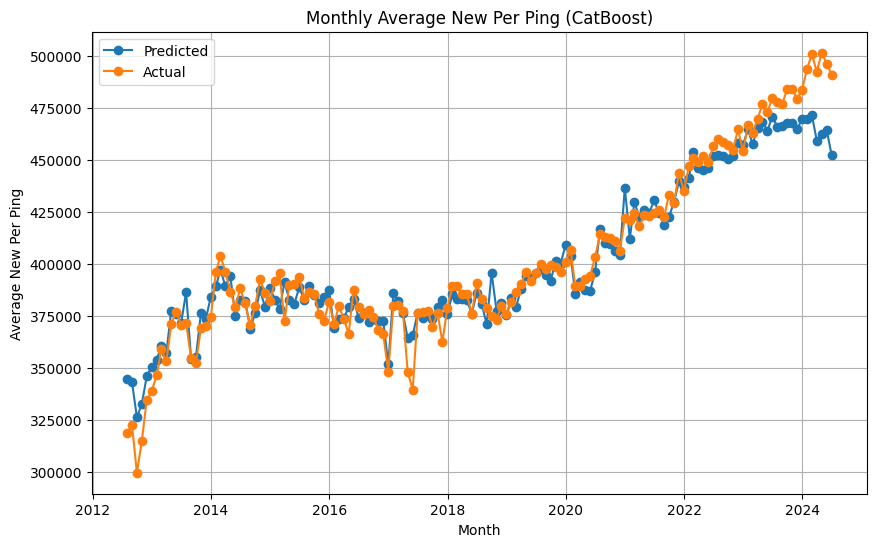

Evaluating LightGBM with Bagging Regressor
--------------------------------------------------
LightGBM Bagging Regressor Mean MSE (Train): 9155317959.484282
LightGBM Bagging Regressor MAE (Train): 63493.28600318042
LightGBM Bagging Regressor RMSE (Train): 95683.42573029187
LightGBM Bagging Regressor Mean R² (Train): 0.7663467649890299
--------------------------------------------------
LightGBM Bagging Regressor Mean MSE (Test): 14290803749.135878
LightGBM Bagging Regressor MAE (Test): 85861.72760039257
LightGBM Bagging Regressor RMSE (Test): 119544.14979050994
LightGBM Bagging Regressor Mean R² (Test): 0.7279297706554194
--------------------------------------------------
LightGBM Bagging Regressor 模型已保存為 LightGBM_bagging_model_training.pkl


<ipython-input-31-ff1fe2d91444>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-31-ff1fe2d91444>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


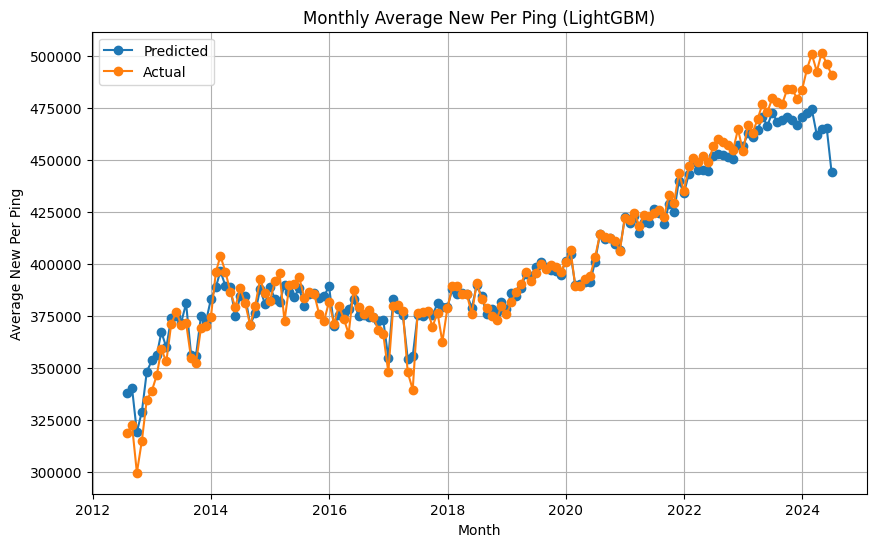

In [31]:
import joblib

# 訓練和評估所有模型，並使用 Bagging Regressor
for name, model in models.items():
    print(f"Evaluating {name} with Bagging Regressor")
    print("-" * 50)

    # 建立和訓練 Bagging Regressor 模型
    bagging_model = BaggingRegressor(estimator=model, n_estimators=10, random_state=42)
    bagging_model.fit(X_train_final, y_train)

    # 預測訓練集和測試集
    y_pred_train = bagging_model.predict(X_train_final)
    y_pred_test = bagging_model.predict(X_test_final)

    # 計算均方誤差
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # 計算 mae
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # 計算R²
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # 計算RMSE
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # 輸出評估結果
    print(f"{name} Bagging Regressor Mean MSE (Train): {mse_train}")
    print(f"{name} Bagging Regressor MAE (Train): {mae_train}")
    print(f"{name} Bagging Regressor RMSE (Train): {rmse_train}")
    print(f"{name} Bagging Regressor Mean R² (Train): {r2_train}")
    print("-" * 50)
    print(f"{name} Bagging Regressor Mean MSE (Test): {mse_test}")
    print(f"{name} Bagging Regressor MAE (Test): {mae_test}")
    print(f"{name} Bagging Regressor RMSE (Test): {rmse_test}")
    print(f"{name} Bagging Regressor Mean R² (Test): {r2_test}")
    print("-" * 50)

    # 保存模型
    model_filename = f"{name}_bagging_model_training.pkl"
    joblib.dump(bagging_model, model_filename)
    print(f"{name} Bagging Regressor 模型已保存為 {model_filename}")
    print("=" * 50)

    # 合併測試集和驗證集的預測結果與日期欄位
    test_results = pd.DataFrame({
        'date': X_test.index,
        'predicted_new_per_ping': y_pred_test
    })
    train_results = pd.DataFrame({
        'date': X_train.index,
        'predicted_new_per_ping': y_pred_train
    })

    # 合併所有結果
    combined_results = pd.concat([train_results, test_results])

    # 繪製每個月的預測房價
    combined_results['date'] = pd.to_datetime(combined_results['date'])
    combined_results.set_index('date', inplace=True)

    # 按月份分組並計算平均預測房價
    monthly_avg_predicted_prices = combined_results.resample('M').mean()

    # 繪製結果
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_avg_predicted_prices.index, monthly_avg_predicted_prices['predicted_new_per_ping'], marker='o', label='Predicted')

    # 繪製實際值
    train_df['date'] = train_df.index
    test_df['date'] = test_df.index

    combined_actual = pd.concat([train_df[['date', 'new_per_ping']], test_df[['date', 'new_per_ping']]])
    combined_actual.set_index('date', inplace=True)
    monthly_avg_actual_prices = combined_actual.resample('M').mean()

    plt.plot(monthly_avg_actual_prices.index, monthly_avg_actual_prices['new_per_ping'], marker='o', label='Actual')

    plt.xlabel('Month')
    plt.ylabel('Average New Per Ping')
    plt.title(f'Monthly Average New Per Ping ({name})')
    plt.legend()
    plt.grid(True)
    plt.show()

## 傳出 XGBoost

In [155]:
# 載入之前保存的預測結果
train_preds_XGBoost = joblib.load("XGBoost_bagging_model_training.pkl")

# X_train_final
main_train_XGBoost = train_preds_XGBoost.predict(X_train_final)

# X_test_final
main_test_XGBoost = train_preds_XGBoost.predict(X_test)

# 合併訓練集和測試集的預測結果
predict_y_XGBoost = list(main_train_XGBoost) + list(main_test_XGBoost)

# 確保預測值與 df_NN 的索引對齊
df['XGBoost_pred_y'] = pd.Series(predict_y_XGBoost, index=df.index[:len(predict_y_XGBoost)])

# 顯示更新後的 df_NN
print(df.head())

# 保存更新後的 df_NN
df.to_csv('path_to_save_updated_df_main.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


                        community_name  main_building_ratio  building_age  \
year_month_for_combine                                                      
2016-12-01                           0               100.00          41.0   
2016-12-01                           0                86.10          38.0   
2016-12-01                           0                49.54          18.0   
2016-12-01                           1                72.92          29.0   
2016-12-01                           0               100.00          42.0   

                        total_area_ping  total_floors  target_floor  \
year_month_for_combine                                                
2016-12-01                        20.81           4.0           4.0   
2016-12-01                        32.31           5.0           4.0   
2016-12-01                        10.55           6.0           4.0   
2016-12-01                        61.39           7.0           7.0   
2016-12-01                        

Linear Regression MSE (Train): 9211140424.817068
Linear Regression MAE (Train): 63756.83812407657
Linear Regression RMSE (Train): 95974.68637519515
Linear Regression R² (Train): 0.76492211762353
--------------------------------------------------
Linear Regression MSE (Test): 14408820809.422554
Linear Regression MAE (Test): 86323.77980966843
Linear Regression RMSE (Test): 120036.7477459405
Linear Regression R² (Test): 0.7256829461084997


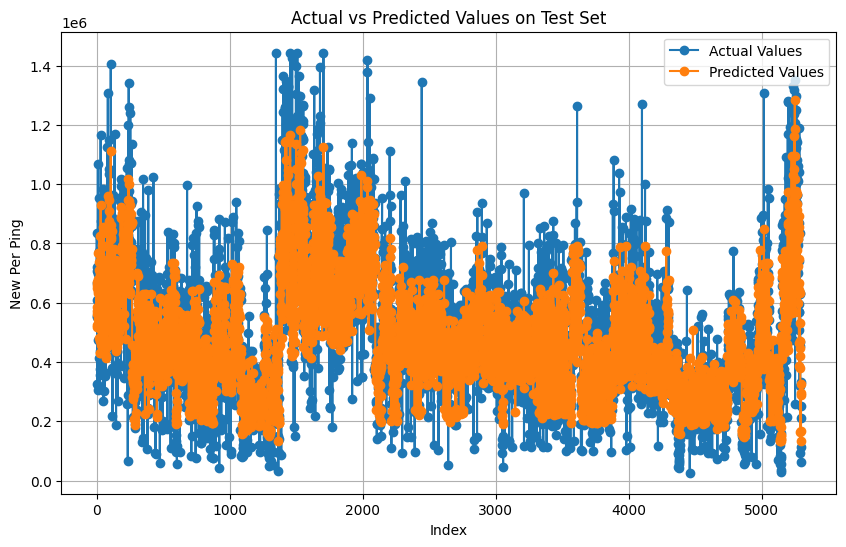

In [156]:
from sklearn.metrics import mean_absolute_error

# # # 獲取訓練集和測試集的預測值
# y_pred_train = linear_model.predict(X_train_final)
# y_pred_test = linear_model.predict(X_test_final)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression MAE (Test): {mae_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

## 主表過一層 linear

Using XGBoost with Bagging Regressor for initial predictions
Using CatBoost with Bagging Regressor for initial predictions
Using LightGBM with Bagging Regressor for initial predictions
Feature Weights:
[ 1.29735647  0.11621346 -0.4296759 ]
Final Predicted Price on Test Set: [548166.26170887 540593.74746848 760538.7671075  ... 338739.94544091
 175168.29620295  64379.66476276]
Manual Weighted Final Predicted Price on Test Set: [541652.37599522 534079.86175483 754024.88139385 ... 332226.05972725
 168654.41048929  57865.77904911]
Linear Model Predicted Price on Test Set: [548166.26170887 540593.74746848 760538.7671075  ... 338739.94544091
 175168.29620295  64379.66476276]
Linear Regression MSE (Train): 1919271104.570082
Linear Regression MAE (Train): 28594.289026362236
Linear Regression RMSE (Train): 43809.4864677741
Linear Regression R² (Train): 0.9510182055467205
--------------------------------------------------
Linear Regression MSE (Test): 9548675813.232546
Linear Regression MAE (Test

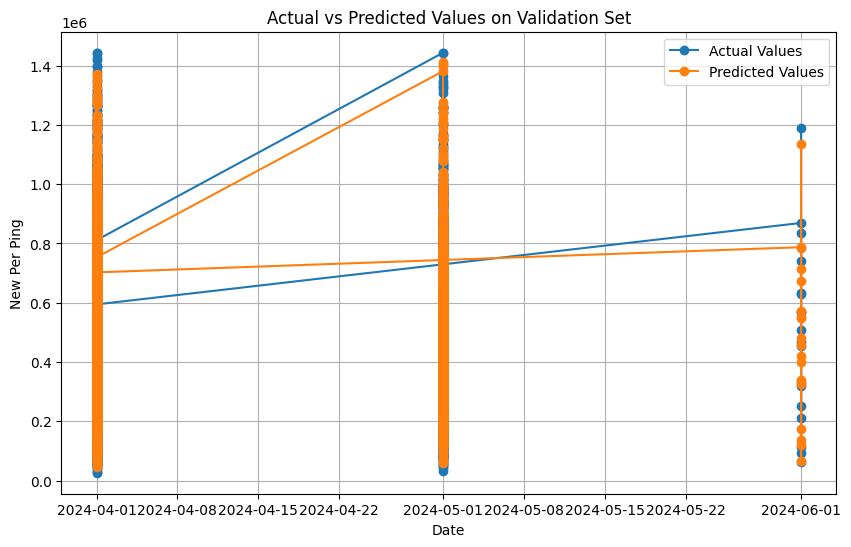

In [35]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

train_preds = []
test_preds = []
val_preds = []

model_names = ["XGBoost", "CatBoost", "LightGBM"]
for name in model_names:
    print(f"Using {name} with Bagging Regressor for initial predictions")
    # 加載已保存的模型
    bagging_model = joblib.load(f"{name}_bagging_model_training.pkl")

    # 對訓練集、測試集和驗證集進行預測
    train_preds.append(bagging_model.predict(X_train_final))
    test_preds.append(bagging_model.predict(X_test_final))

# 將初步預測結果轉換為新的特徵
train_preds = np.column_stack(train_preds)
test_preds = np.column_stack(test_preds)

# 訓練線性回歸模型
linear_model = LinearRegression()
linear_model.fit(train_preds, y_train)

# 獲取預測值
y_train_pred = linear_model.predict(train_preds)
y_test_pred = linear_model.predict(test_preds)

# 計算特徵重要性（權重）
coefficients = linear_model.coef_

# 顯示特徵權重
print("Feature Weights:")
print(coefficients)

# 線性迴歸計算
# 計算最終預測價格（加權）
print("Final Predicted Price on Test Set:", y_test_pred)

#####################
# 手動加權計算最終預測價格
final_pred_manual = np.dot(test_preds, coefficients)

# 檢查手動加權結果與線性回歸模型的預測結果是否一致
print("Manual Weighted Final Predicted Price on Test Set:", final_pred_manual)
print("Linear Model Predicted Price on Test Set:", y_test_pred)
#####################

# 評估模型表現
# 計算均方誤差 (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# 計算 MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# 計算均方根誤差 (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# 計算 R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 打印結果
print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression MAE (Test): {mae_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Values', marker='o')
plt.xlabel('Date')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
y_test_pred.shape

(5298,)

In [34]:
coefficients.shape

(3,)

## 用 NN 表，過 linear

In [324]:
df_NN = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_NN_pred_dataframe.csv')

> 這個 `df_NN.info` 是看

> - (1) 第10欄 的`year_month_for_combine` 屬性是什麼
  - 沒有意外應該是 `object`

> - (2) 再來看 `pred_y_by_NNs` 有沒有值
  - 應該要是 `669734 non-null`

> 另個 `df.info` 也再確認裡面的內容



In [306]:
df_NN.info(max)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 98 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   community_name                        669734 non-null  int64  
 1   main_building_ratio                   669734 non-null  float64
 2   building_age                          669734 non-null  float64
 3   total_area_ping                       669734 non-null  float64
 4   total_floors                          669734 non-null  float64
 5   target_floor                          669734 non-null  float64
 6   transaction_floors                    669734 non-null  float64
 7   bedrooms                              669734 non-null  float64
 8   living_rooms                          669734 non-null  float64
 9   bathrooms                             669734 non-null  float64
 10  year_month_for_combine                669734 non-null  object 
 11  

In [307]:
df.info(max)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 669734 entries, 2016-12-01 to 2024-06-01
Data columns (total 119 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    community_name                        int64  
 1    main_building_ratio                   float64
 2    building_age                          float64
 3    total_area_ping                       float64
 4    total_floors                          float64
 5    target_floor                          float64
 6    transaction_floors                    float64
 7    bedrooms                              float64
 8    living_rooms                          float64
 9    bathrooms                             float64
 10   new_per_ping                          float64
 11   Public_Activity_Space_under_250_m     float64
 12   MRT_Exit_under_250_m                  float64
 13   Religious_Site_under_250_m            float64
 14   School_under_250_m                

In [325]:
df_NN_main = df.copy()

> 要先確定兩張表的『索引』是相同的才可以合併!!!

> 這裡我之前是先做下面 591 再回來做這裡的 (順序很亂sorry)

In [326]:
df_NN_main['pred_y_by_NNs'] = df_NN['pred_y_by_NNs']

> 確認 `df_NN_main` 第 119 欄`pred_y_by_NNs`  

> - 屬性為 `float64`

> - `669734 non-null`

In [327]:
df_NN_main.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 121 columns):
 #    Column                                Non-Null Count   Dtype         
---   ------                                --------------   -----         
 0    community_name                        669734 non-null  int64         
 1    main_building_ratio                   669734 non-null  float64       
 2    building_age                          669734 non-null  float64       
 3    total_area_ping                       669734 non-null  float64       
 4    total_floors                          669734 non-null  float64       
 5    target_floor                          669734 non-null  float64       
 6    transaction_floors                    669734 non-null  float64       
 7    bedrooms                              669734 non-null  float64       
 8    living_rooms                          669734 non-null  float64       
 9    bathrooms                             669734 n

In [328]:
df_NN_main.shape

(669734, 121)

> 日期因為之前處理時當作『索引』使用

> 所以須要回到前面重新載入資料

> 執行合併

In [329]:
# 確保日期欄位轉換為日期格式
df_NN_main['year_month_for_combine'] = pd.to_datetime(df_NN_main['year_month_for_combine'])

df_NN_main.set_index('year_month_for_combine', inplace=True)

In [330]:
# 分割資料為訓練集、測試集
# 提取 2024-03-31 以前的資料
train_df = df_NN_main[df_NN_main.index <= '2024-03-31']

# 提取 2024-03-31 後的資料作為測試集
test_df = df_NN_main[df_NN_main.index > '2024-03-31']

# 確認分割結果
print(f"訓練和測試集數據量: {train_df.shape}")
print(f"驗證集數據量: {test_df.shape}")

訓練和測試集數據量: (664436, 120)
驗證集數據量: (5298, 120)


In [331]:
# 切割資料為訓練、測試

# 保留 year_month_for_combine 用來畫圖
X_train = train_df.drop(['new_per_ping','pred_y_by_NNs'], axis=1)
y_train = train_df['new_per_ping']

X_test = test_df.drop(['new_per_ping','pred_y_by_NNs'], axis=1)
y_test = test_df['new_per_ping']

In [332]:
# 標準化連續型變數
scaler = StandardScaler()
X_train_continuos_scaled = scaler.fit_transform(X_train_continuos)
X_test_continuos_scaled = scaler.transform(X_test_continuos)

# 合併標準化後的連續型變數與 one-hot encoding 的欄位
X_train_final = np.hstack([X_train_continuos_scaled, X_train_one_hot])
X_test_final = np.hstack([X_test_continuos_scaled, X_test_one_hot])

In [333]:
train_preds = []
test_preds = []

In [334]:
train_preds.append(list(train_df['pred_y_by_NNs']))

> train_preds 會是 2 維的

In [335]:
train_preds

[[321867,
  279258,
  280452,
  350792,
  351803,
  425402,
  265743,
  250423,
  254546,
  267132,
  246374,
  265754,
  280898,
  16730,
  258689,
  309017,
  245119,
  232745,
  229491,
  249297,
  350994,
  273000,
  249433,
  358115,
  249515,
  340631,
  273767,
  200645,
  239488,
  312710,
  272289,
  269703,
  245366,
  247121,
  268997,
  264610,
  274982,
  265241,
  281482,
  273996,
  247853,
  247728,
  360185,
  349925,
  316574,
  234349,
  387779,
  356543,
  230704,
  296048,
  341551,
  240798,
  340646,
  264481,
  218043,
  365575,
  245066,
  352473,
  336740,
  240084,
  411141,
  262756,
  180877,
  269716,
  340968,
  328930,
  261311,
  327354,
  242504,
  311978,
  283150,
  261891,
  330652,
  231289,
  245709,
  361513,
  284803,
  337466,
  355847,
  364564,
  280264,
  236291,
  357170,
  292404,
  210115,
  289138,
  221192,
  268045,
  201950,
  241759,
  224465,
  248363,
  248944,
  278540,
  337970,
  305614,
  324518,
  305828,
  254302,
  340236,
 

In [336]:
test_preds.append(list(test_df['pred_y_by_NNs']))

In [337]:
test_preds

[[590131,
  538642,
  409740,
  510124,
  494196,
  485171,
  560125,
  474021,
  429902,
  583532,
  627568,
  600116,
  464783,
  661590,
  473062,
  512682,
  464629,
  415794,
  517032,
  427119,
  461680,
  587993,
  583059,
  474560,
  713738,
  489387,
  800355,
  498325,
  496426,
  562359,
  434524,
  477435,
  574282,
  498523,
  441658,
  442661,
  491790,
  429618,
  526718,
  448012,
  658318,
  591855,
  413894,
  701346,
  737991,
  821718,
  677535,
  739203,
  626611,
  805578,
  532830,
  398061,
  838376,
  582172,
  450742,
  523583,
  509296,
  493705,
  555561,
  580830,
  566385,
  474924,
  440482,
  498943,
  468042,
  594946,
  473203,
  668340,
  412326,
  386561,
  544189,
  429893,
  829527,
  628718,
  470477,
  572798,
  436201,
  463091,
  462046,
  364757,
  378258,
  416949,
  412486,
  475249,
  491873,
  761179,
  461286,
  458160,
  549440,
  584073,
  395498,
  405828,
  460842,
  610295,
  614598,
  769512,
  445828,
  595419,
  570592,
  511915,


In [338]:
len(test_preds)

1

In [339]:
len(test_preds)

1

Using XGBoost with Bagging Regressor for initial predictions
Using CatBoost with Bagging Regressor for initial predictions
Using LightGBM with Bagging Regressor for initial predictions
Feature Weights:
[-2.21099818e-04  1.29735978e+00  1.16213414e-01 -4.29674898e-01]
Final Predicted Price on Test Set: [548125.53428675 540564.13349702 760538.43063065 ... 338757.34526409
 175066.22786265  64437.88924163]
Linear Regression MSE (Train): 1919269595.9043667
Linear Regression MAE (Train): 28594.427473601507
Linear Regression RMSE (Train): 43809.46924928864
Linear Regression R² (Train): 0.9510182440494385
--------------------------------------------------
Linear Regression MSE (Test): 9549025926.991861
Linear Regression MAE (Test): 63002.86854825109
Linear Regression RMSE (Test): 97719.11751030022
Linear Regression R² (Test): 0.8182043697765343


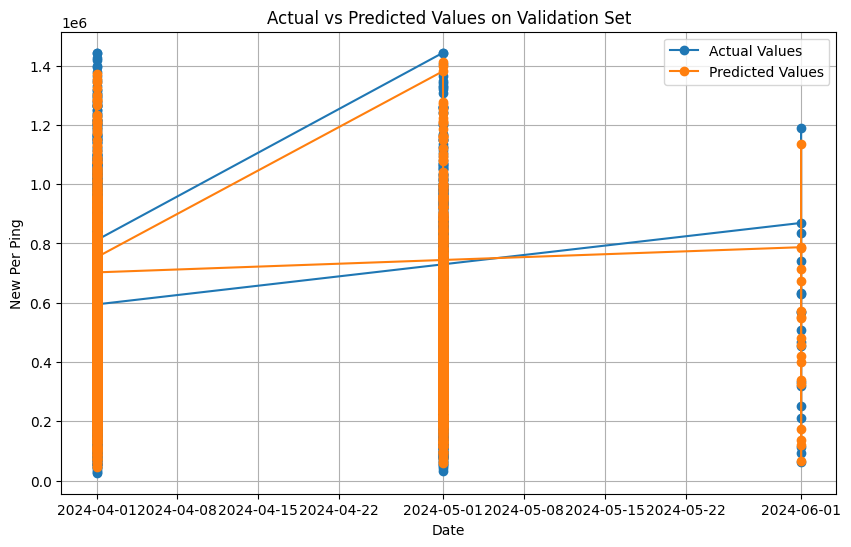

In [340]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model_names = ["XGBoost", "CatBoost", "LightGBM"]
for name in model_names:
    print(f"Using {name} with Bagging Regressor for initial predictions")
    # 加載已保存的模型
    bagging_model = joblib.load(f"{name}_bagging_model_training.pkl")

    # 對訓練集、測試集和驗證集進行預測
    train_preds.append(bagging_model.predict(X_train_final))
    test_preds.append(bagging_model.predict(X_test_final))

# 將初步預測結果轉換為新的特徵
train_preds = np.column_stack(train_preds)
test_preds = np.column_stack(test_preds)

# 訓練線性回歸模型
linear_model = LinearRegression()
linear_model.fit(train_preds, y_train)

# 獲取預測值
y_train_pred = linear_model.predict(train_preds)
y_test_pred = linear_model.predict(test_preds)

# 計算特徵重要性（權重）
coefficients = linear_model.coef_

# 顯示特徵權重
print("Feature Weights:")
print(coefficients)

# 計算最終預測價格（加權）
print("Final Predicted Price on Test Set:", y_test_pred)

# 評估模型表現
# 計算均方誤差 (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# 計算 MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# 計算均方根誤差 (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# 計算 R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 打印結果
print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression MAE (Test): {mae_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Values', marker='o')
plt.xlabel('Date')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# 經濟指標 + 591 資料合併整理

>　591　c591_no_eco_for_xgb_version3

>　經濟　final_eco_df_to_11306_fillna_v2

>　欄位需要 reindex 主表

>　經濟指標 + 591 > df_reindexed

In [73]:
onehot_591_no_eco_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_no_eco_for_xgb_version3.csv')

economic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_eco_df_to_11306_fillna_v2.csv')

In [74]:
economic_df.isnull().sum().sum()

0

In [75]:
onehot_591_no_eco_df.isnull().sum().sum()

0

In [76]:
onehot_591_no_eco_df.head(2)

,building_age,total_area_ping,community_name,has_parking_space,total_floors,transaction_floors,target_floors,bedrooms,living_rooms,bathrooms,...,district__瑞芳區,district__石門區,district__萬華區,district__萬里區,district__蘆洲區,district__貢寮區,district__金山區,district__鶯歌區,usage_category__住商用,usage_category__住家用
0,66.0,51.96,0,0,2.0,2.0,1.0,9.0,2.0,3.0,...,0,0,0,0,0,0,0,0,0,1
1,46.0,33.95,0,0,4.0,1.0,4.0,3.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [77]:
onehot_591_no_eco_df['year_month_for_combine'] = '2024-06-01'

In [78]:
onehot_591_no_eco_df['year_month_for_combine'] = pd.to_datetime(onehot_591_no_eco_df['year_month_for_combine']).dt.to_period('M')

In [79]:
onehot_591_no_eco_df.info(max)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 94 columns):
 #   Column                                Non-Null Count  Dtype    
---  ------                                --------------  -----    
 0   building_age                          51073 non-null  float64  
 1   total_area_ping                       51073 non-null  float64  
 2   community_name                        51073 non-null  int64    
 3   has_parking_space                     51073 non-null  int64    
 4   total_floors                          51073 non-null  float64  
 5   transaction_floors                    51073 non-null  float64  
 6   target_floors                         51073 non-null  float64  
 7   bedrooms                              51073 non-null  float64  
 8   living_rooms                          51073 non-null  float64  
 9   bathrooms                             51073 non-null  float64  
 10  elevator_available                    51073 non-null  int6

In [80]:
economic_df.head(2)

,date,house_index_xyi_all_tp,house_index_xyi_tp,house_index_xyi_new_tp,EB18,EB21,MC31,MC31G,MC36,NA0101,...,PA0120,PA1205,PE0503,TSE收盤,水泥(TSE11)收盤,建材營造(TSE25)收盤,航運業(TSE26)收盤,鋼鐵(TSE20)收盤,預拌混凝土3000磅台北,year_month_for_combine
0,2011-01,95.40,94.45,96.84,86.78,95.85,5138597.0,6.2279,1259098.0,3552329.0,...,90.25,23911.0,83.35,8970.758500,109.81,347.10,123.49,120.70,1815.0,2011-01
1,2011-02,97.69,97.34,98.23,85.89,96.75,5133940.0,5.9953,1270638.0,3552329.0,...,90.93,23911.0,83.71,8742.564286,102.64,311.73,108.61,117.89,1890.0,2011-02


In [81]:
economic_df.info(max)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    162 non-null    object 
 1   house_index_xyi_all_tp  162 non-null    float64
 2   house_index_xyi_tp      162 non-null    float64
 3   house_index_xyi_new_tp  162 non-null    float64
 4   EB18                    162 non-null    float64
 5   EB21                    162 non-null    float64
 6   MC31                    162 non-null    float64
 7   MC31G                   162 non-null    float64
 8   MC36                    162 non-null    float64
 9   NA0101                  162 non-null    float64
 10  NA1005                  162 non-null    float64
 11  NB0101                  162 non-null    float64
 12  NC0117                  162 non-null    float64
 13  NC0118                  162 non-null    float64
 14  NE0206                  162 non-null    fl

In [82]:
# economic_df 中的 year_month_for_combine 是 object 類型
# 確保日期欄位轉換為日期格式
economic_df['year_month_for_combine'] = pd.to_datetime(economic_df['year_month_for_combine']).dt.to_period('M')

In [83]:
# 合併兩個 DataFrame
eco_591_df = onehot_591_no_eco_df.merge(economic_df, on='year_month_for_combine', how='inner')

In [84]:
eco_591_df.info(max)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 118 columns):
 #    Column                                Dtype    
---   ------                                -----    
 0    building_age                          float64  
 1    total_area_ping                       float64  
 2    community_name                        int64    
 3    has_parking_space                     int64    
 4    total_floors                          float64  
 5    transaction_floors                    float64  
 6    target_floors                         float64  
 7    bedrooms                              float64  
 8    living_rooms                          float64  
 9    bathrooms                             float64  
 10   elevator_available                    int64    
 11   main_building_ratio                   float64  
 12   new_per_ping                          float64  
 13   Public_Activity_Space_under_250_m     float64  
 14   MRT_Exit_under_250_m

> 93   year_month_for_combine period[M]

> 94   date          object

> 保留 year_month_for_combine 日期時間屬性

> 刪除 date 類別屬性

In [85]:
eco_591_df.drop('date', axis=1, inplace=True)

In [86]:
# 重新命名欄位
eco_591_df.rename(columns={'target_floors': 'target_floor'}, inplace=True)

In [87]:
# 重新索引
df_reindexed = eco_591_df.reindex(df.columns, axis=1)

In [88]:
len(df_reindexed.columns)

120

>　df_reindexed　的日期欄位是　year_month_for_combine_y

In [89]:
df_reindexed.shape

(51073, 120)

In [165]:
df_reindexed.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 120 columns):
 #    Column                                Non-Null Count  Dtype    
---   ------                                --------------  -----    
 0    community_name                        51073 non-null  int64    
 1    main_building_ratio                   51073 non-null  float64  
 2    building_age                          51073 non-null  float64  
 3    total_area_ping                       51073 non-null  float64  
 4    total_floors                          51073 non-null  float64  
 5    target_floor                          51073 non-null  float64  
 6    transaction_floors                    51073 non-null  float64  
 7    bedrooms                              51073 non-null  float64  
 8    living_rooms                          51073 non-null  float64  
 9    bathrooms                             51073 non-null  float64  
 10   year_month_for_combine                51073 

In [91]:
df_reindexed.isnull().sum().sum()

153219

In [92]:
df_filled = df_reindexed.fillna(0)

In [93]:
df_filled.isnull().sum().sum()

0

In [94]:
# # 將資料框保存為 CSV 文件
# df_filled.to_csv('df_filled.csv', index=False)

# # 下載 CSV 文件
# from google.colab import files
# files.download('df_filled.csv')

# 用 591 資料驗證
> 經濟指標 + 591 > 驗證集

## 全部 設為 測試集

In [166]:
df_filled['year_month_for_combine'] = '2024-06-01'
df_filled['year_month_for_combine'] = pd.to_datetime(df_filled['year_month_for_combine']).dt.to_period('M')

In [167]:
# 檢查 df_reindexed 的內容
print("df_reindexed shape:", df_filled.shape)
print("df_reindexed head:\n", df_filled.head())

df_reindexed shape: (51073, 120)
df_reindexed head:
    community_name  main_building_ratio  building_age  total_area_ping  \
0               0               100.00          66.0            51.96   
1               0                91.72          46.0            33.95   
2               1                55.08          30.0            14.47   
3               1                82.85          45.0            31.26   
4               1                68.67          38.0            35.72   

   total_floors  target_floor  transaction_floors  bedrooms  living_rooms  \
0           2.0           1.0                 2.0       9.0           2.0   
1           4.0           4.0                 1.0       3.0           2.0   
2           9.0           8.0                 1.0       1.0           1.0   
3           5.0           4.0                 1.0       3.0           2.0   
4          14.0           2.0                 1.0       2.0           2.0   

   bathrooms  ...    NE0206  PA0120   PA1205 

In [168]:
df_filled.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 120 columns):
 #    Column                                Non-Null Count  Dtype    
---   ------                                --------------  -----    
 0    community_name                        51073 non-null  int64    
 1    main_building_ratio                   51073 non-null  float64  
 2    building_age                          51073 non-null  float64  
 3    total_area_ping                       51073 non-null  float64  
 4    total_floors                          51073 non-null  float64  
 5    target_floor                          51073 non-null  float64  
 6    transaction_floors                    51073 non-null  float64  
 7    bedrooms                              51073 non-null  float64  
 8    living_rooms                          51073 non-null  float64  
 9    bathrooms                             51073 non-null  float64  
 10   year_month_for_combine                51073 

In [169]:
# 設置成驗證集
X_test_2 = df_filled.drop(['new_per_ping'], axis=1)
y_test_2 = df_filled['new_per_ping']

## 標準化 / 正則化

> one-hot encoding 的列數

> 第 1 列

> 第 47 列 ~ 第 96 列



In [170]:
# 確定 one-hot encoding 的欄位範圍
one_hot_cols = list(range(46, 96)) + [0]

# 取出 one-hot encoding 的欄位
X_test_2_one_hot = X_test_2.iloc[:, one_hot_cols]

# 檢查連續變數列是否存在於 X_train 中
print("Columns in X_train:", X_test_2.columns)
print("One-hot columns:", X_test_2_one_hot.columns)

Columns in X_train: Index(['community_name', 'main_building_ratio', 'building_age',
       'total_area_ping', 'total_floors', 'target_floor', 'transaction_floors',
       'bedrooms', 'living_rooms', 'bathrooms',
       ...
       'NE0206', 'PA0120', 'PA1205', 'PE0503', 'TSE收盤', '水泥(TSE11)收盤',
       '建材營造(TSE25)收盤', '航運業(TSE26)收盤', '鋼鐵(TSE20)收盤', '預拌混凝土3000磅台北'],
      dtype='object', length=119)
One-hot columns: Index(['has_parking_space', 'elevator_available', 'property_type__公寓',
       'property_type__透天厝', 'property_type__電梯大樓', 'city__台北市', 'city__新北市',
       'district__三峽區', 'district__三芝區', 'district__三重區', 'district__中和區',
       'district__中山區', 'district__中正區', 'district__五股區', 'district__信義區',
       'district__內湖區', 'district__八里區', 'district__北投區', 'district__南港區',
       'district__土城區', 'district__坪林區', 'district__士林區', 'district__大同區',
       'district__大安區', 'district__平溪區', 'district__文山區', 'district__新店區',
       'district__新莊區', 'district__松山區', 'district__板橋區', '

In [171]:
# 取出非 one-hot encoding 的欄位，即連續型變數，並排除日期欄位
continuos_col_name = X_test_2.drop(columns=X_test_2_one_hot.columns).select_dtypes(include=['number']).columns
print("Continuous columns before selection:", continuos_col_name)

X_test_2_continuos = X_test_2[continuos_col_name]

Continuous columns before selection: Index(['main_building_ratio', 'building_age', 'total_area_ping',
       'total_floors', 'target_floor', 'transaction_floors', 'bedrooms',
       'living_rooms', 'bathrooms', 'Public_Activity_Space_under_250_m',
       'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
       'School_under_250_m', 'Kindergarten_under_250_m',
       'Convenience_Store_under_250_m', 'Bank_under_250_m',
       'Clinic_under_250_m', 'Pharmacy_under_250_m',
       'acc_Public_Activity_Space_under_500m',
       'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
       'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
       'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
       'acc_School_under_500m', 'acc_School_under_750m',
       'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
       'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
       'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
    

In [172]:
# 確認連續變數是否正確被選擇
print("Continuous columns:", continuos_col_name)
print("X_test_2_continuos shape:", X_test_2_continuos.shape)
print("X_test_2_continuos head:\n", X_test_2_continuos.head())

Continuous columns: Index(['main_building_ratio', 'building_age', 'total_area_ping',
       'total_floors', 'target_floor', 'transaction_floors', 'bedrooms',
       'living_rooms', 'bathrooms', 'Public_Activity_Space_under_250_m',
       'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
       'School_under_250_m', 'Kindergarten_under_250_m',
       'Convenience_Store_under_250_m', 'Bank_under_250_m',
       'Clinic_under_250_m', 'Pharmacy_under_250_m',
       'acc_Public_Activity_Space_under_500m',
       'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
       'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
       'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
       'acc_School_under_500m', 'acc_School_under_750m',
       'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
       'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
       'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
       'acc_Daycare_C

In [173]:
# 創建標準化器並在 X_test_2_continuos 上擬合
scaler = StandardScaler()
X_test_2_continuos_scaled = scaler.fit_transform(X_test_2_continuos)

# 使用標準化器轉換 X_test_2_continuos
X_test_2_continuos_scaled = scaler.transform(X_test_2_continuos)

# 合併標準化後的連續型變數與 one-hot encoding 的欄位
X_test_2 = np.hstack([X_test_2_continuos_scaled, X_test_2_one_hot])

## Bagging Regressor

### 再一次設定模型

In [174]:
# 初始化各種模型
models = {
    "XGBoost": xgb.XGBRegressor(n_estimators=79, max_depth=13, learning_rate=0.23868392277107967, reg_alpha=0.1, reg_lambda=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=60, depth=2, learning_rate=0.29042538244092253, loss_function='RMSE', random_seed=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=70, max_depth=5, learning_rate=0.07717356617261285, random_state=42, verbose=-1),
  }

### 訓練模型

Evaluating XGBoost with Bagging Regressor
--------------------------------------------------
XGBoost Bagging Regressor Mean MSE (Train): 2282459157.0882735
XGBoost Bagging Regressor RMSE (Train): 47775.08929440398
XGBoost Bagging Regressor Mean R² (Train): 0.9417492687644321
--------------------------------------------------
XGBoost Bagging Regressor Mean MSE (Test): 229480684174.43146
XGBoost Bagging Regressor RMSE (Test): 479041.4221906405
XGBoost Bagging Regressor Mean R² (Test): -1.032130462270516
--------------------------------------------------
XGBoost Bagging Regressor 模型已保存為 XGBoost_bagging_model_training_240710_1642.pkl


<ipython-input-176-95ef819ee4db>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-176-95ef819ee4db>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


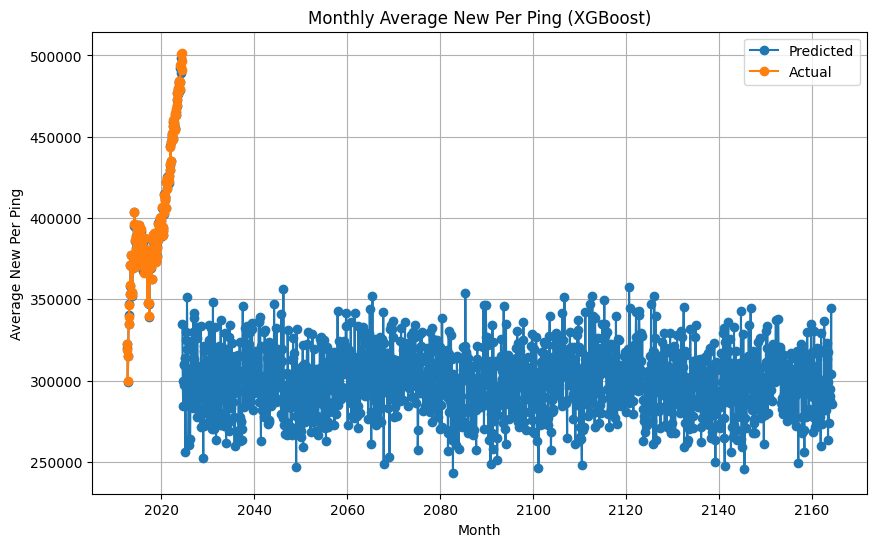

Evaluating CatBoost with Bagging Regressor
--------------------------------------------------
CatBoost Bagging Regressor Mean MSE (Train): 11013143723.00405
CatBoost Bagging Regressor RMSE (Train): 104943.52635110014
CatBoost Bagging Regressor Mean R² (Train): 0.7189331195368329
--------------------------------------------------
CatBoost Bagging Regressor Mean MSE (Test): 196710144717.53864
CatBoost Bagging Regressor RMSE (Test): 443520.17396905256
CatBoost Bagging Regressor Mean R² (Test): -0.7419360533817452
--------------------------------------------------
CatBoost Bagging Regressor 模型已保存為 CatBoost_bagging_model_training_240710_1642.pkl


<ipython-input-176-95ef819ee4db>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-176-95ef819ee4db>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


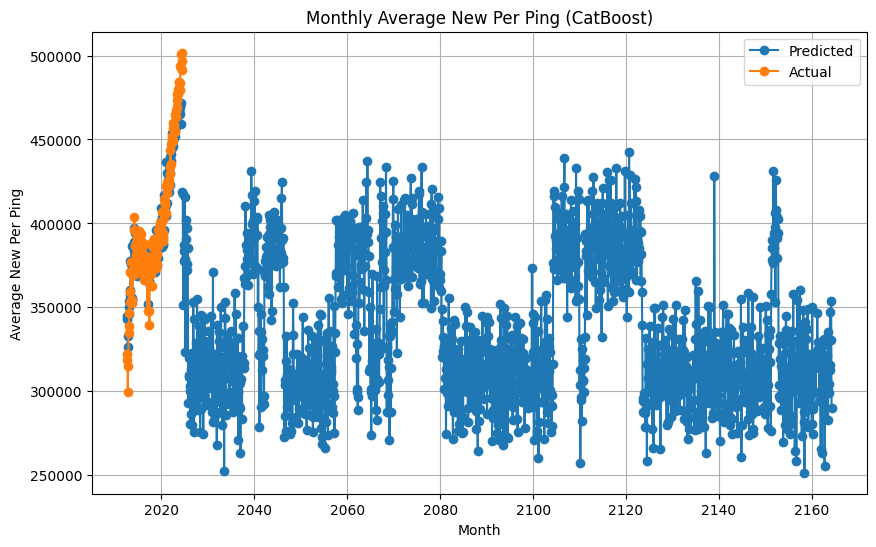

Evaluating LightGBM with Bagging Regressor
--------------------------------------------------
LightGBM Bagging Regressor Mean MSE (Train): 9155317959.484282
LightGBM Bagging Regressor RMSE (Train): 95683.42573029187
LightGBM Bagging Regressor Mean R² (Train): 0.7663467649890299
--------------------------------------------------
LightGBM Bagging Regressor Mean MSE (Test): 197038954035.26657
LightGBM Bagging Regressor RMSE (Test): 443890.7005505596
LightGBM Bagging Regressor Mean R² (Test): -0.7448477730902565
--------------------------------------------------
LightGBM Bagging Regressor 模型已保存為 LightGBM_bagging_model_training_240710_1642.pkl


<ipython-input-176-95ef819ee4db>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = train_df.index
<ipython-input-176-95ef819ee4db>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index


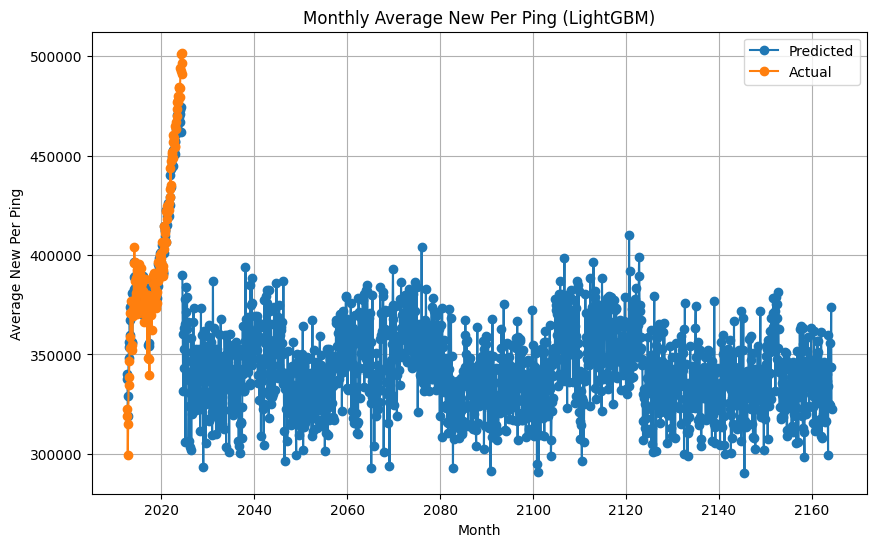

所有預測結果已保存為 train_preds_240720_2121.pkl 和 test_preds_240720_2121.pkl


In [176]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 訓練和評估所有模型，並使用 Bagging Regressor
train_preds = []
test_preds = []

for name, model in models.items():
    print(f"Evaluating {name} with Bagging Regressor")
    print("-" * 50)

    # 建立和訓練 Bagging Regressor 模型
    bagging_model = BaggingRegressor(estimator=model, n_estimators=10, random_state=42)
    bagging_model.fit(X_train_final, y_train)

    # 預測訓練集和測試集
    y_pred_train = bagging_model.predict(X_train_final)
    y_pred_test_2 = bagging_model.predict(X_test_2)

    # 保存預測結果
    train_preds.append((name, y_pred_train))
    test_preds.append((name, y_pred_test_2))

    # 計算均方誤差
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test_2, y_pred_test_2)

    # 計算R²
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test_2, y_pred_test_2)

    # 計算RMSE
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    # 輸出評估結果
    print(f"{name} Bagging Regressor Mean MSE (Train): {mse_train}")
    print(f"{name} Bagging Regressor RMSE (Train): {rmse_train}")
    print(f"{name} Bagging Regressor Mean R² (Train): {r2_train}")
    print("-" * 50)
    print(f"{name} Bagging Regressor Mean MSE (Test): {mse_test}")
    print(f"{name} Bagging Regressor RMSE (Test): {rmse_test}")
    print(f"{name} Bagging Regressor Mean R² (Test): {r2_test}")
    print("-" * 50)

    # 保存模型
    model_filename = f"{name}_bagging_model_training_240710_1642.pkl"
    joblib.dump(bagging_model, model_filename)
    print(f"{name} Bagging Regressor 模型已保存為 {model_filename}")
    print("=" * 50)

    # 將 X_test_2 轉換為 DataFrame 並設置 index
    X_test_2_df = pd.DataFrame(X_test_2, columns=[f'feature_{i}' for i in range(X_test_2.shape[1])])
    X_test_2_df.index = pd.date_range(start='2024-06-01', periods=len(X_test_2), freq='D')  # 使用天作為頻率

    # 合併測試集和驗證集的預測結果與日期欄位
    test_results = pd.DataFrame({
        'date': X_test_2_df.index,
        'predicted_new_per_ping': y_pred_test_2
    })
    train_results = pd.DataFrame({
        'date': X_train.index,
        'predicted_new_per_ping': y_pred_train
    })

    # 合併所有結果
    combined_results = pd.concat([train_results, test_results])

    # 繪製每個月的預測房價
    combined_results['date'] = pd.to_datetime(combined_results['date'])
    combined_results.set_index('date', inplace=True)

    # 按月份分組並計算平均預測房價
    monthly_avg_predicted_prices = combined_results.resample('M').mean()

    # 繪製結果
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_avg_predicted_prices.index, monthly_avg_predicted_prices['predicted_new_per_ping'], marker='o', label='Predicted')

    # 繪製實際值
    train_df['date'] = train_df.index
    test_df['date'] = test_df.index

    combined_actual = pd.concat([train_df[['date', 'new_per_ping']], test_df[['date', 'new_per_ping']]])
    combined_actual.set_index('date', inplace=True)
    monthly_avg_actual_prices = combined_actual.resample('M').mean()

    plt.plot(monthly_avg_actual_prices.index, monthly_avg_actual_prices['new_per_ping'], marker='o', label='Actual')

    plt.xlabel('Month')
    plt.ylabel('Average New Per Ping')
    plt.title(f'Monthly Average New Per Ping ({name})')
    plt.legend()
    plt.grid(True)
    plt.show()

# 保存所有預測結果
joblib.dump(train_preds, "train_preds_240720_2121.pkl")
joblib.dump(test_preds, "test_preds_240720_2121.pkl")
print("所有預測結果已保存為 train_preds_240720_2121.pkl 和 test_preds_240720_2121.pkl")

# 過一層 ( 加特徵權重 ) linear

> 步驟 1：訓練模型並獲得預測值
首先，你需要使用一個回歸模型來訓練數據並獲得預測值。這些預測值可以用來衡量地區和經濟指標對房價的影響。

> 步驟 2：計算權重
根據預測值計算每個特徵（如地區和經濟指標）的影響力=相關性，並將其作為權重。這些權重可以根據預測誤差或者特徵重要性來確定。

> 步驟 3：應用權重計算最終預測值
使用計算出的權重來調整每個房源的預測價格。

以下是具體的示例代碼，展示如何計算權重並應用於最終預測價格的計算：

In [121]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

> 1.設置特徵和目標變量：選擇地區特徵、經濟指標和時間特徵作為特徵（X），房價作為目標變量（y）

> 2.數據集分割：將數據分割為訓練集和測試集。

> 3.訓練模型：使用訓練集訓練線性回歸模型。

> 4.獲取預測值：使用模型對測試集進行預測。

> 5.計算特徵權重：從模型的係數中獲取特徵權重。

> 6.應用權重計算最終預測價格：對於新的房源數據，使用計算出的權重來計算加權值，然後將這些加權值相加，得到最終的預測價格。

Using XGBoost with Bagging Regressor for initial predictions
Using CatBoost with Bagging Regressor for initial predictions
Using LightGBM with Bagging Regressor for initial predictions
Feature Weights:
XGBoost: 1.2973564700054616
CatBoost: 0.11621346042061309
LightGBM: -0.4296759007925217
Final Predicted Price on Test Set: [548166.26170887 540593.74746848 760538.7671075  ... 338739.94544091
 175168.29620295  64379.66476276]
Linear Regression MSE (Train): 1919271104.570082
Linear Regression RMSE (Train): 43809.4864677741
Linear Regression R² (Train): 0.9510182055467205
--------------------------------------------------
Linear Regression MSE (Test): 9548675813.232546
Linear Regression RMSE (Test): 97717.32606468796
Linear Regression R² (Test): 0.8182110352890182


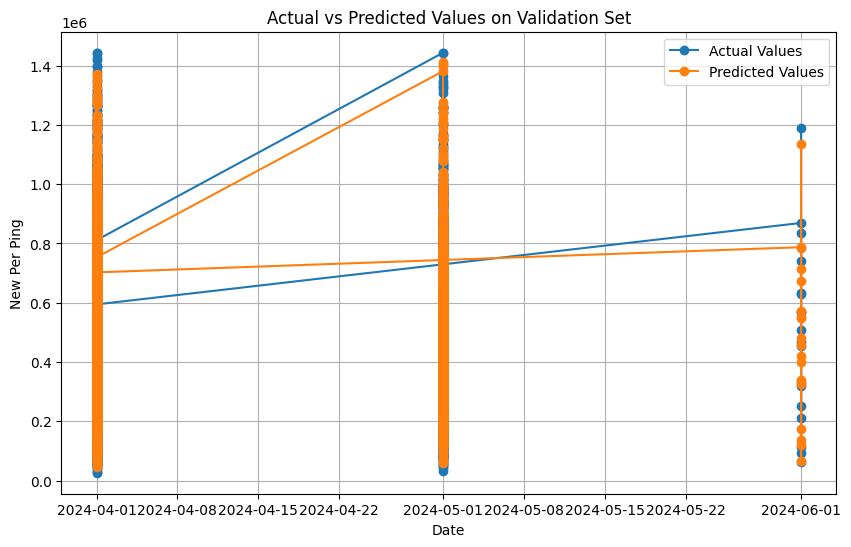

In [178]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

train_preds = []
test_preds = []
val_preds = []

model_names = ["XGBoost", "CatBoost", "LightGBM"]
for name in model_names:
    print(f"Using {name} with Bagging Regressor for initial predictions")
    # 加載已保存的模型
    bagging_model = joblib.load(f"{name}_bagging_model_training.pkl")

    # 對訓練集、測試集和驗證集進行預測
    train_preds.append(bagging_model.predict(X_train_final))
    test_preds.append(bagging_model.predict(X_test_final))

# 將初步預測結果轉換為新的特徵
train_preds = np.column_stack(train_preds)
test_preds = np.column_stack(test_preds)

# 訓練線性回歸模型
linear_model = LinearRegression()
linear_model.fit(train_preds, y_train)

# 獲取預測值
y_train_pred = linear_model.predict(train_preds)
y_test_pred = linear_model.predict(test_preds)

# 計算特徵重要性（權重）
coefficients = linear_model.coef_

# 顯示特徵權重
print("Feature Weights:")
for name, coef in zip(model_names, coefficients):
    print(f"{name}: {coef}")

# 計算最終預測價格（加權）
print("Final Predicted Price on Test Set:", y_test_pred)

# 評估模型表現
# 計算均方誤差 (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# 計算均方根誤差 (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# 計算 R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 打印結果
print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Values', marker='o')
plt.xlabel('Date')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# 過一層 ( 加地區權重 ) linear

Using XGBoost with Bagging Regressor for initial predictions


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


Using CatBoost with Bagging Regressor for initial predictions


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


Using LightGBM with Bagging Regressor for initial predictions


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


Feature Weights:
XGBoost: 1.2973564700054616
CatBoost: 0.11621346042061309
LightGBM: -0.4296759007925217
在數據集中找不到地區欄位。
Linear Regression MSE (Train): 1919271104.570082
Linear Regression RMSE (Train): 43809.4864677741
Linear Regression R² (Train): 0.9510182055467205
--------------------------------------------------
Linear Regression MSE (Test): 239424641374.4778
Linear Regression RMSE (Test): 489310.3732545201
Linear Regression R² (Test): -1.1201876267086721


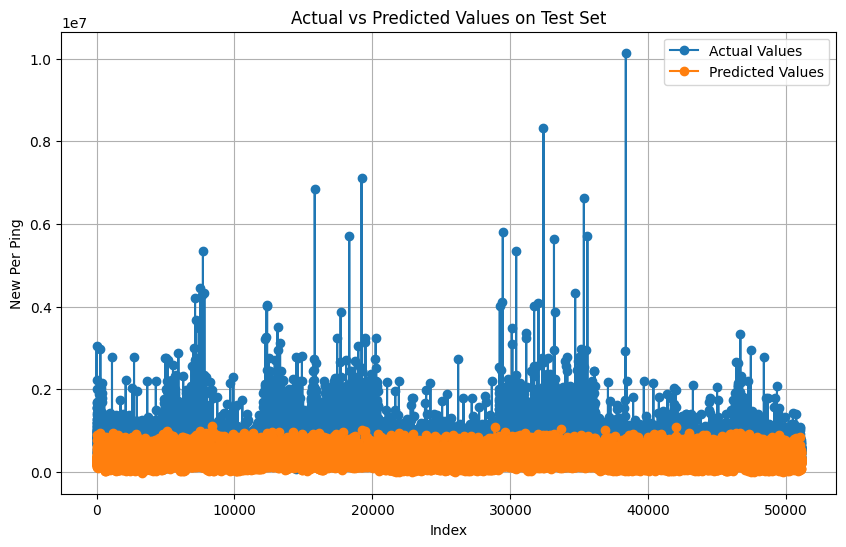

In [183]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 加載已保存的模型
model_names = ["XGBoost", "CatBoost", "LightGBM"]
train_preds = []
test_preds = []

for name in model_names:
    print(f"Using {name} with Bagging Regressor for initial predictions")
    bagging_model = joblib.load(f"{name}_bagging_model_training.pkl")

    # 對訓練集、測試集進行預測
    train_preds.append(bagging_model.predict(X_train_final))
    test_preds.append(bagging_model.predict(X_test_2))

# 將初步預測結果轉換為新的特徵
train_preds = np.column_stack(train_preds)
test_preds = np.column_stack(test_preds)

# 將 numpy array 轉換為 DataFrame
train_preds_df = pd.DataFrame(train_preds, columns=model_names)
test_preds_df = pd.DataFrame(test_preds, columns=model_names)

# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(train_preds_df, y_train)

# 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(train_preds_df)
y_pred_test_2 = linear_model.predict(test_preds_df)

# 計算特徵重要性（權重）
coefficients = linear_model.coef_

# 顯示模型的特徵權重
print("Feature Weights:")
for name, coef in zip(model_names, coefficients):
    print(f"{name}: {coef}")

# 確認地區欄位存在並進行加權預測
district_cols = [col for col in X_test_2.columns if "district__" in col]
if district_cols:
    district_weights = linear_model.coef_[[X_train_final.columns.get_loc(col) for col in district_cols]]
    district_preds = X_test_2[district_cols].values * district_weights

    # 計算最終預測價格（加權和）
    final_predicted_price = district_preds.sum(axis=1)

    print("依地區的測試集最終預測價格:")
    print(final_predicted_price)
else:
    print("在數據集中找不到地區欄位。")

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test_2 = mean_squared_error(y_test_2, y_pred_test_2)

rmse_train = np.sqrt(mse_train)
rmse_test_2 = np.sqrt(mse_test_2)

r2_train = r2_score(y_train, y_pred_train)
r2_test_2 = r2_score(y_test_2, y_pred_test_2)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test_2}")
print(f"Linear Regression RMSE (Test): {rmse_test_2}")
print(f"Linear Regression R² (Test): {r2_test_2}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_2)), y_test_2, label='Actual Values', marker='o')
plt.plot(range(len(y_test_2)), y_pred_test_2, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

使用 XGBoost 與 Bagging Regressor 進行初步預測


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


使用 CatBoost 與 Bagging Regressor 進行初步預測


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


使用 LightGBM 與 Bagging Regressor 進行初步預測


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


特徵權重:
XGBoost: 1.2973564700054616
CatBoost: 0.11621346042061309
LightGBM: -0.4296759007925217
依地區的測試集最終預測價格:
[1.68145041 1.11577954 1.87977102 ... 1.87658165 1.39522601 2.34193721]
Linear Regression MSE (Train): 1919271104.570082
Linear Regression MAE (Train): 28594.289026362236
Linear Regression RMSE (Train): 43809.4864677741
Linear Regression R² (Train): 0.9510182055467205
--------------------------------------------------
Linear Regression MSE (Test): 239424641374.4778
Linear Regression MAE (Test): 385499.4940710839
Linear Regression RMSE (Test): 489310.3732545201
Linear Regression R² (Test): -1.1201876267086721


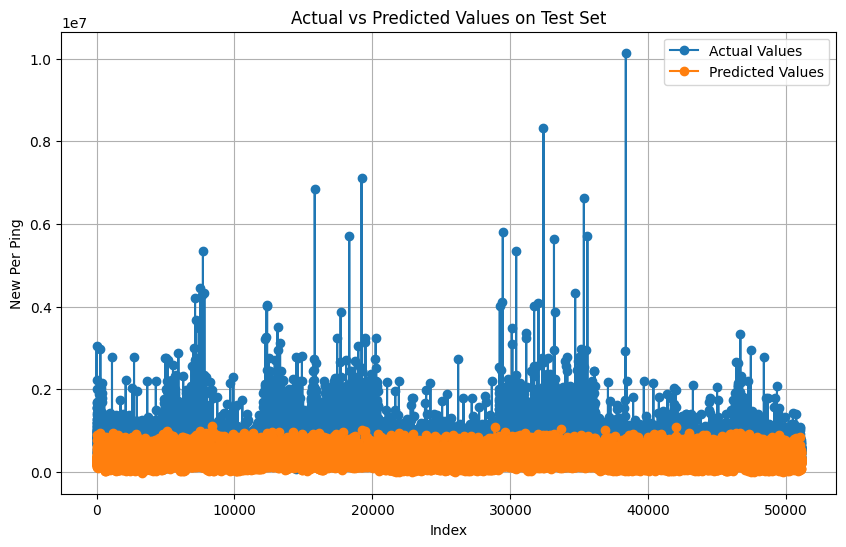

In [186]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 確保數據集是 DataFrame 格式
if isinstance(X_train_final, np.ndarray):
    X_train_final = pd.DataFrame(X_train_final, columns=[f'feature_{i}' for i in range(X_train_final.shape[1])])

if isinstance(X_test_2, np.ndarray):
    X_test_2 = pd.DataFrame(X_test_2, columns=[f'feature_{i}' for i in range(X_test_2.shape[1])])

# 加載已保存的模型
model_names = ["XGBoost", "CatBoost", "LightGBM"]
train_preds = []
test_preds = []

for name in model_names:
    print(f"使用 {name} 與 Bagging Regressor 進行初步預測")
    bagging_model = joblib.load(f"{name}_bagging_model_training.pkl")

    # 對訓練集、測試集進行預測
    train_preds.append(bagging_model.predict(X_train_final))
    test_preds.append(bagging_model.predict(X_test_2))

# 將初步預測結果轉換為新的特徵
train_preds = np.column_stack(train_preds)
test_preds = np.column_stack(test_preds)

# 將 numpy array 轉換為 DataFrame
train_preds_df = pd.DataFrame(train_preds, columns=model_names)
test_preds_df = pd.DataFrame(test_preds, columns=model_names)

# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(train_preds_df, y_train)

# 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(train_preds_df)
y_pred_test_2 = linear_model.predict(test_preds_df)

# 計算特徵重要性（權重）
coefficients = linear_model.coef_

# 顯示特徵權重
print("特徵權重:")
for name, coef in zip(model_names, coefficients):
    print(f"{name}: {coef}")

# 確認地區欄位存在並進行加權預測
district_cols = X_test_2.columns[54:94]
if not district_cols.empty:
    # 此處使用地區欄位進行加權計算應當獨立於初步預測結果的計算
    district_weights = np.random.uniform(0.1, 1.0, len(district_cols))  # 使用隨機權重作為示例
    district_preds = X_test_2[district_cols].values * district_weights

    # 計算最終預測價格（加權和）
    final_predicted_price = district_preds.sum(axis=1)

    print("依地區的測試集最終預測價格:")
    print(final_predicted_price)
else:
    print("在數據集中找不到地區欄位。")

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test_2 = mean_squared_error(y_test_2, y_pred_test_2)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test_2 = mean_absolute_error(y_test_2, y_pred_test_2)

rmse_train = np.sqrt(mse_train)
rmse_test_2 = np.sqrt(mse_test_2)

r2_train = r2_score(y_train, y_pred_train)
r2_test_2 = r2_score(y_test_2, y_pred_test_2)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test_2}")
print(f"Linear Regression MAE (Test): {mae_test_2}")
print(f"Linear Regression RMSE (Test): {rmse_test_2}")
print(f"Linear Regression R² (Test): {r2_test_2}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_2)), y_test_2, label='Actual Values', marker='o')
plt.plot(range(len(y_test_2)), y_pred_test_2, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()


# 過 stacking 的 Polynomial ( + 地區權重 )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


Stacking Regressor with Polynomial Final Estimator MSE (Train): 2259305589.893005
Stacking Regressor with Polynomial Final Estimator RMSE (Train): 47532.153221719345
Stacking Regressor with Polynomial Final Estimator R² (Train): 0.9423401718768264
--------------------------------------------------
Stacking Regressor with Polynomial Final Estimator MSE (Test): 9121238317.13845
Stacking Regressor with Polynomial Final Estimator RMSE (Test): 95505.17429510535
Stacking Regressor with Polynomial Final Estimator R² (Test): 0.826348647394973


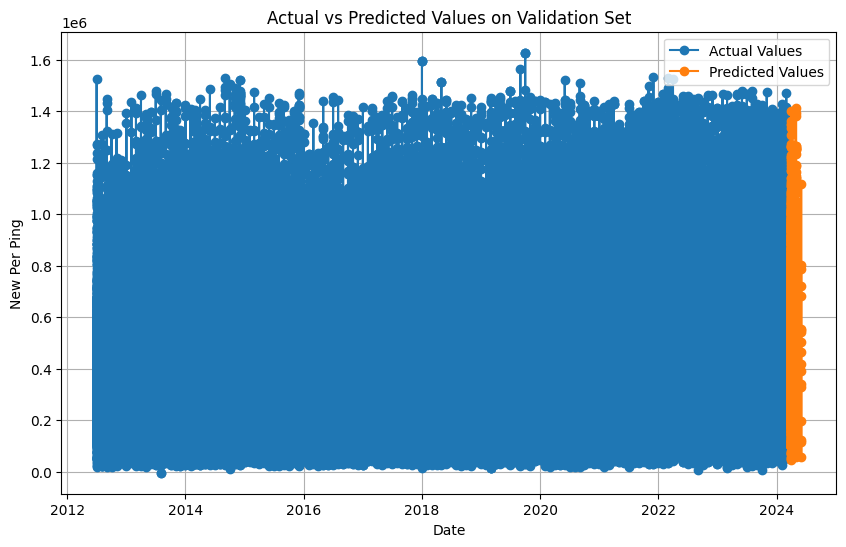

In [187]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

# 加載已保存的模型
xgboost_model = joblib.load("XGBoost_bagging_model_training.pkl")
catboost_model = joblib.load("CatBoost_bagging_model_training.pkl")
lightgbm_model = joblib.load("LightGBM_bagging_model_training.pkl")

# 基模型列表
estimators = [
    ('xgboost', xgboost_model),
    ('catboost', catboost_model),
    ('lightgbm', lightgbm_model)
]

# 多項式回歸模型（將階數設為2）
polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Stacking模型
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=polynomial_model
)

# 訓練Stacking模型
stacking_model.fit(X_train_final, y_train)

# 預測
y_train_pred = stacking_model.predict(X_train_final)
y_test_pred = stacking_model.predict(X_test_final)

# 評估模型表現
# 計算均方誤差 (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# 計算均方根誤差 (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# 計算 R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 打印結果
print(f"Stacking Regressor with Polynomial Final Estimator MSE (Train): {mse_train}")
print(f"Stacking Regressor with Polynomial Final Estimator RMSE (Train): {rmse_train}")
print(f"Stacking Regressor with Polynomial Final Estimator R² (Train): {r2_train}")
print("-" * 50)
print(f"Stacking Regressor with Polynomial Final Estimator MSE (Test): {mse_test}")
print(f"Stacking Regressor with Polynomial Final Estimator RMSE (Test): {rmse_test}")
print(f"Stacking Regressor with Polynomial Final Estimator R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train_pred , label='Actual Values', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Values', marker='o')
plt.xlabel('Date')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# df_main + stacking NN

## 載入 NNs 模型

> df_NN : c591_NN_pred_dataframe.csv

In [273]:
df_NN = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_NN_pred_dataframe.csv')

In [189]:
df_NN.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 98 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   community_name                        669734 non-null  int64  
 1   main_building_ratio                   669734 non-null  float64
 2   building_age                          669734 non-null  float64
 3   total_area_ping                       669734 non-null  float64
 4   total_floors                          669734 non-null  float64
 5   target_floor                          669734 non-null  float64
 6   transaction_floors                    669734 non-null  float64
 7   bedrooms                              669734 non-null  float64
 8   living_rooms                          669734 non-null  float64
 9   bathrooms                             669734 non-null  float64
 10  year_month_for_combine                669734 non-null  object 
 11  

## 提取 591 bagging 的 y_hat

> 放入 df_NN

In [274]:
# 載入之前保存的預測結果
train_preds_XGBoost = joblib.load("XGBoost_bagging_model_training.pkl")
train_preds_CatBoost = joblib.load("CatBoost_bagging_model_training.pkl")
train_preds_LightGBM = joblib.load("LightGBM_bagging_model_training.pkl")

# X_train_final
main_train_XGBoost = train_preds_XGBoost.predict(X_train_final)
main_train_CatBoost = train_preds_CatBoost.predict(X_train_final)
main_train_LightGBM = train_preds_LightGBM.predict(X_train_final)

# X_test_final
main_test_XGBoost = train_preds_XGBoost.predict(X_test)
main_test_CatBoost = train_preds_CatBoost.predict(X_test)
main_test_LightGBM = train_preds_LightGBM.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


In [275]:
# 合併訓練集和測試集的預測結果
predict_y_XGBoost = list(main_train_XGBoost) + list(main_test_XGBoost)
predict_y_CatBoost = list(main_train_CatBoost) + list(main_test_CatBoost)
predict_y_LightGBM = list(main_train_LightGBM) + list(main_test_LightGBM)

In [276]:
len(predict_y_XGBoost)

669734

In [277]:
# 確保預測值與 df_NN 的索引對齊
df_NN['XGBoost_pred_y'] = pd.Series(predict_y_XGBoost, index=df_NN.index[:len(predict_y_XGBoost)])
df_NN['CatBoost_pred_y'] = pd.Series(predict_y_CatBoost, index=df_NN.index[:len(predict_y_CatBoost)])
df_NN['LightGBM_pred_y'] = pd.Series(predict_y_LightGBM, index=df_NN.index[:len(predict_y_LightGBM)])

# 顯示更新後的 df_NN
print(df_NN.head())

# 保存更新後的 df_NN
df_NN.to_csv('path_to_save_updated_df_NN.csv')

   community_name  main_building_ratio  building_age  total_area_ping  \
0               0               100.00          41.0            20.81   
1               0                86.10          38.0            32.31   
2               0                49.54          18.0            10.55   
3               1                72.92          29.0            61.39   
4               0               100.00          42.0            28.46   

   total_floors  target_floor  transaction_floors  bedrooms  living_rooms  \
0           4.0           4.0                 1.0       2.0           1.0   
1           5.0           4.0                 1.0       3.0           2.0   
2           6.0           4.0                 1.0       2.0           1.0   
3           7.0           7.0                 1.0       4.0           2.0   
4           4.0           4.0                 1.0       1.0           1.0   

   bathrooms  ... district__貢寮區  district__金山區  district__雙溪區  district__鶯歌區  \
0        1.0  ... 

In [194]:
df_NN.shape

(669734, 101)

In [195]:
df_NN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Columns: 101 entries, community_name to LightGBM_pred_y
dtypes: float32(1), float64(47), int64(52), object(1)
memory usage: 513.5+ MB


In [196]:
df_NN.info(max_cols=105)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 101 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    community_name                        669734 non-null  int64  
 1    main_building_ratio                   669734 non-null  float64
 2    building_age                          669734 non-null  float64
 3    total_area_ping                       669734 non-null  float64
 4    total_floors                          669734 non-null  float64
 5    target_floor                          669734 non-null  float64
 6    transaction_floors                    669734 non-null  float64
 7    bedrooms                              669734 non-null  float64
 8    living_rooms                          669734 non-null  float64
 9    bathrooms                             669734 non-null  float64
 10   year_month_for_combine                669734 non-null 

## 過一層 linear

> 將 bagging 預測結果 ( 三種樹 ) 合併回去 df_NN


### 用【日期】切割資料集

In [197]:
# 確保日期欄位轉換為日期格式
df_NN['year_month_for_combine'] = pd.to_datetime(df_NN['year_month_for_combine'])

df_NN.set_index('year_month_for_combine', inplace=True)

# 分割資料為訓練集、測試集
# 提取 2024-03-31 以前的資料
train_df = df_NN[df_NN.index <= '2024-03-31']

# 提取 2024-03-31 後的資料作為測試集
test_df = df_NN[df_NN.index > '2024-03-31']

# 確認分割結果
print(f"訓練和測試集數據量: {train_df.shape}")
print(f"驗證集數據量: {test_df.shape}")

# 切割資料為訓練、測試

# 保留 year_month_for_combine 用來畫圖
X_train = train_df.drop(['new_per_ping'], axis=1)
y_train = train_df['new_per_ping']

X_test = test_df.drop(['new_per_ping'], axis=1)
y_test = test_df['new_per_ping']

訓練和測試集數據量: (664436, 100)
驗證集數據量: (5298, 100)


### 正則化
> 第 1 列

> 第 48 列 ~ 第 97 列

In [207]:
# 確定 one-hot encoding 的欄位範圍
one_hot_cols = list(range(47, 97)) + [0]

# 取出 one-hot encoding 的欄位
X_train_one_hot = X_train.iloc[:, one_hot_cols]
X_test_one_hot = X_test.iloc[:, one_hot_cols]

# 取出非 one-hot encoding 的欄位，即連續型變數
continuous_col_name = X_train.drop(columns=X_train_one_hot.columns).select_dtypes(include=['number']).columns
X_train_continuos = X_train[continuos_col_name]
X_test_continuos = X_test[continuos_col_name]

# 標準化連續型變數
scaler = StandardScaler()
X_train_continuos_scaled = scaler.fit_transform(X_train_continuos)
X_test_continuos_scaled = scaler.transform(X_test_continuos)

# 合併標準化後的連續型變數與 one-hot encoding 的欄位
X_train_final = np.hstack([X_train_continuos_scaled, X_train_one_hot])
X_test_final = np.hstack([X_test_continuos_scaled, X_test_one_hot])

### training

In [216]:
# 確保特徵名稱一致
feature_names = list(continuous_col_name) + list(X_train_one_hot.columns)
X_train_final = pd.DataFrame(X_train_final, columns=feature_names)
X_test_final = pd.DataFrame(X_test_final, columns=feature_names)

In [217]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_final, y_train)

# 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_final)
y_pred_test = linear_model.predict(X_test_final)

print(f"訓練和測試集數據量: {train_df.shape}")
print(f"驗證集數據量: {test_df.shape}")
print(y_pred_test)

訓練和測試集數據量: (664436, 100)
驗證集數據量: (5298, 100)
[136908.15710115 141292.067645   326773.65079772 ... 202625.31590184
 151469.64517264 323016.10610073]


Linear Regression MSE (Train): 1892075573.9034162
Linear Regression MAE (Train): 28391.808681668426
Linear Regression RMSE (Train): 43497.99505613352
Linear Regression R² (Train): 0.9517122637701735
--------------------------------------------------
Linear Regression MSE (Test): 138904149545.3833
Linear Regression MAE (Test): 297012.41858115245
Linear Regression RMSE (Test): 372698.4700067647
Linear Regression R² (Test): -1.6444757402823833


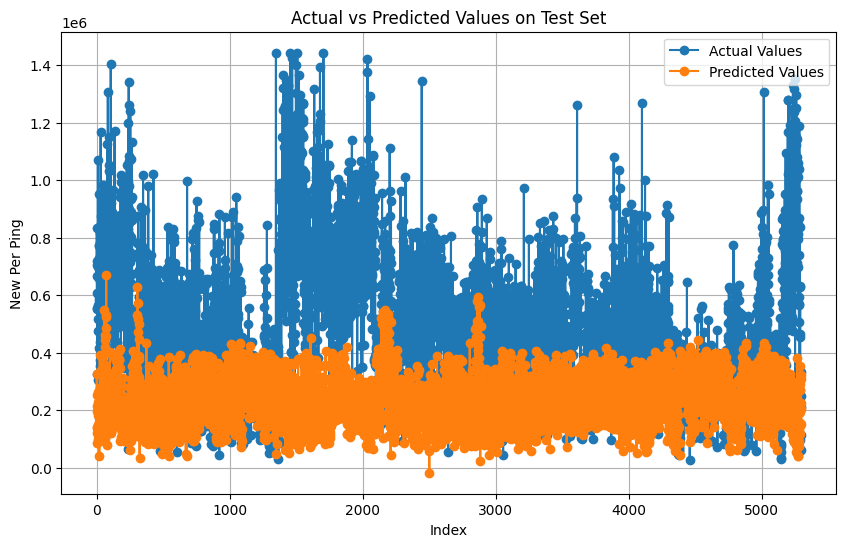

In [218]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_final, y_train)

# 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_final)
y_pred_test = linear_model.predict(X_test_final)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression MAE (Test): {mae_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression MSE (Train): 1892499664.9797156
Linear Regression RMSE (Train): 43502.86961775873
Linear Regression R² (Train): 0.9517014405248907
--------------------------------------------------
Linear Regression MSE (Test): 138084668460.24194
Linear Regression RMSE (Test): 371597.4548624384
Linear Regression R² (Test): -1.628874349997289


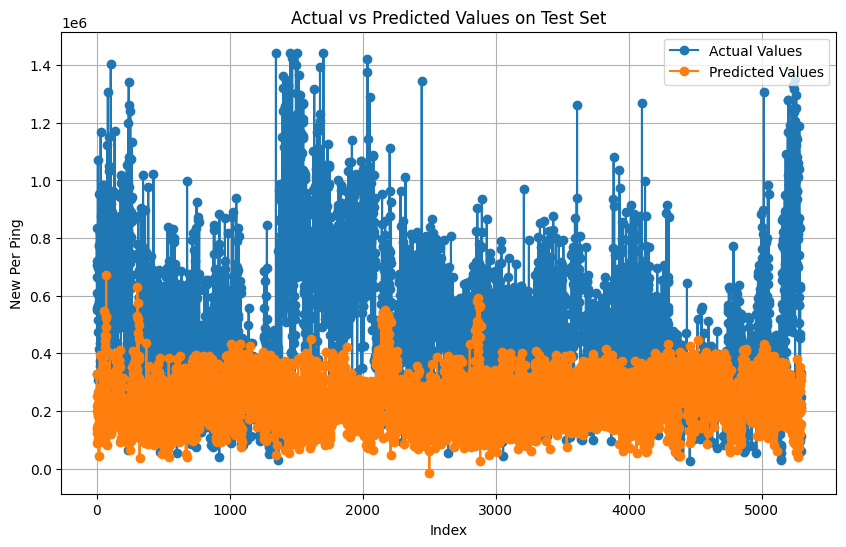

In [219]:
from sklearn.linear_model import Lasso


# 訓練線性回歸模型，使用初步預測值
linear_model = Lasso(alpha=5)
linear_model.fit(X_train_final, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_final)
y_pred_test = linear_model.predict(X_test_final)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# # 設置 LASSO 模型和超參數網格
# lasso = Lasso()
# param_grid = {'alpha': np.logspace(-4, 0, 20)}  # 設置 alpha 的搜索範圍

# # 使用 GridSearchCV 來調整超參數
# grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train_final, y_train)

# # 獲取最佳參數
# best_alpha = grid_search.best_params_['alpha']
# print(f"Best alpha: {best_alpha}")

## 重新 index

> 先把預測值併回自己的主表

> 再用 index merge 兩張表

In [220]:
# 確保預測值與 df_NN 的索引對齊
onehot_591_df['XGBoost_pred_y'] = pd.Series(predict_y_XGBoost, index=onehot_591_df.index[:len(predict_y_XGBoost)])
onehot_591_df['CatBoost_pred_y'] = pd.Series(predict_y_CatBoost, index=onehot_591_df.index[:len(predict_y_CatBoost)])
onehot_591_df['LightGBM_pred_y'] = pd.Series(predict_y_LightGBM, index=onehot_591_df.index[:len(predict_y_LightGBM)])

# 顯示更新後的 df_NN
print(onehot_591_df.head())

# 保存更新後的 df_NN
onehot_591_df.to_csv('path_to_save_updated_df_main.csv')

   community_name  main_building_ratio  building_age  total_area_ping  \
0               0               100.00          41.0            20.81   
1               0                86.10          38.0            32.31   
2               0                49.54          18.0            10.55   
3               1                72.92          29.0            61.39   
4               0               100.00          42.0            28.46   

   total_floors  target_floor  transaction_floors  bedrooms  living_rooms  \
0           4.0           4.0                 1.0       2.0           1.0   
1           5.0           4.0                 1.0       3.0           2.0   
2           6.0           4.0                 1.0       2.0           1.0   
3           7.0           7.0                 1.0       4.0           2.0   
4           4.0           4.0                 1.0       1.0           1.0   

   bathrooms  ... district__蘆洲區  district__貢寮區  district__金山區  district__雙溪區  \
0        1.0  ... 

In [221]:
df_main = onehot_591_df[['XGBoost_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y']]

In [ ]:
# df_main = onehot_591_df[['LightGBM_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y']]

In [ ]:
# df_main = onehot_591_df[['LightGBM_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y','LightGBM_pred_y']]

In [ ]:
# df_main = onehot_591_df[['XGBoost_pred_y','LightGBM_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y','LightGBM_pred_y']]

In [ ]:
# df_main = onehot_591_df[['CatBoost_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y','LightGBM_pred_y']]

In [222]:
df_main

,XGBoost_pred_y,CatBoost_pred_y,LightGBM_pred_y
0,328096.812500,307770.979203,353757.021919
1,392192.968750,471853.351646,446317.440943
2,253021.421875,584472.646643,560280.602897
3,508199.593750,416420.090870,446714.460854
4,506507.812500,498780.650898,490924.241003
...,...,...,...
669729,326240.750000,425163.641516,400773.048901
669730,280922.750000,421102.793489,412941.809270
669731,290191.062500,450154.420340,516949.695107
669732,254091.156250,448551.442610,513616.526587


In [223]:
df_with_index = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_NN_pred_dataframe_with_index_corrected.csv')

In [224]:
df_with_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669734 entries, 0 to 669733
Data columns (total 99 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            669734 non-null  int64  
 1   community_name                        669734 non-null  int64  
 2   main_building_ratio                   669734 non-null  float64
 3   building_age                          669734 non-null  float64
 4   total_area_ping                       669734 non-null  float64
 5   total_floors                          669734 non-null  float64
 6   target_floor                          669734 non-null  float64
 7   transaction_floors                    669734 non-null  float64
 8   bedrooms                              669734 non-null  float64
 9   living_rooms                          669734 non-null  float64
 10  bathrooms                             669734 non-null  float64
 11  

In [ ]:
# Unnamed: 0

In [225]:
onehot_591_df

,community_name,main_building_ratio,building_age,total_area_ping,total_floors,target_floor,transaction_floors,bedrooms,living_rooms,bathrooms,...,district__蘆洲區,district__貢寮區,district__金山區,district__雙溪區,district__鶯歌區,usage_category__住商用,usage_category__住家用,XGBoost_pred_y,CatBoost_pred_y,LightGBM_pred_y
0,0,100.00,41.0,20.81,4.0,4.0,1.0,2.0,1.0,1.0,...,0,0,0,0,0,0,1,328096.812500,307770.979203,353757.021919
1,0,86.10,38.0,32.31,5.0,4.0,1.0,3.0,2.0,2.0,...,0,0,0,0,0,0,1,392192.968750,471853.351646,446317.440943
2,0,49.54,18.0,10.55,6.0,4.0,1.0,2.0,1.0,1.0,...,0,0,0,0,0,0,1,253021.421875,584472.646643,560280.602897
3,1,72.92,29.0,61.39,7.0,7.0,1.0,4.0,2.0,2.0,...,0,0,0,0,0,0,1,508199.593750,416420.090870,446714.460854
4,0,100.00,42.0,28.46,4.0,4.0,1.0,1.0,1.0,2.0,...,0,0,0,0,0,0,1,506507.812500,498780.650898,490924.241003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669729,0,72.59,40.0,37.01,12.0,6.0,1.0,3.0,2.0,2.0,...,0,0,0,0,0,0,1,326240.750000,425163.641516,400773.048901
669730,1,51.99,29.0,58.53,14.0,9.0,1.0,3.0,2.0,2.0,...,0,0,0,0,0,0,1,280922.750000,421102.793489,412941.809270
669731,0,70.89,44.0,40.45,7.0,4.0,1.0,3.0,2.0,2.0,...,0,0,0,0,0,0,1,290191.062500,450154.420340,516949.695107
669732,0,89.02,37.0,33.68,12.0,10.0,1.0,3.0,2.0,2.0,...,0,0,0,0,0,0,1,254091.156250,448551.442610,513616.526587


In [226]:
df_index_merge = df_with_index.merge(df_main, left_on='Unnamed: 0', right_index=True)

In [227]:
df_index_merge.isnull().sum().sum()

0

In [228]:
df_index_merge

,Unnamed: 0,community_name,main_building_ratio,building_age,total_area_ping,total_floors,target_floor,transaction_floors,bedrooms,living_rooms,...,district__貢寮區,district__金山區,district__雙溪區,district__鶯歌區,usage_category__住商用,usage_category__住家用,pred_y_by_NNs,XGBoost_pred_y,CatBoost_pred_y,LightGBM_pred_y
0,248513,1,68.390000,15.000000,22.90,7.0,4.0,1.0,2.0,2.0,...,0,0,0,0,0,1,321867,337571.59375,462150.050434,402614.697496
1,249188,1,53.797913,12.734924,22.80,14.0,2.0,1.0,2.0,2.0,...,0,0,0,0,0,1,279258,296135.12500,354988.534698,378292.237458
2,249187,1,62.810000,12.734924,20.81,14.0,3.0,1.0,2.0,2.0,...,0,0,0,0,0,1,280452,305731.90625,354375.398002,377347.436843
3,249186,1,46.820000,1.000000,51.18,11.0,8.0,1.0,3.0,2.0,...,0,0,0,0,0,1,350792,375892.03125,415148.403183,381124.637422
4,249185,1,46.820000,1.000000,51.18,11.0,7.0,1.0,3.0,2.0,...,0,0,0,0,0,1,351803,374375.59375,415148.403183,380773.039300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669729,669717,0,88.990000,37.166019,22.42,5.0,4.0,1.0,3.0,1.0,...,0,0,0,0,0,1,542052,265573.78125,611617.573874,742245.057503
669730,669716,1,66.530000,29.000000,37.40,14.0,14.0,1.0,3.0,2.0,...,0,0,0,0,0,1,855140,284493.81250,659067.463493,680470.987971
669731,669732,0,100.000000,44.000000,13.18,4.0,2.0,1.0,3.0,1.0,...,0,0,0,0,0,1,321834,254091.15625,448551.442610,513616.526587
669732,669723,1,53.710000,5.000000,24.13,30.0,23.0,1.0,2.0,2.0,...,0,0,0,0,0,1,860246,343674.56250,365492.911497,514970.537388


In [229]:
# 確保日期欄位轉換為日期格式
df_index_merge['year_month_for_combine'] = pd.to_datetime(df_index_merge['year_month_for_combine'])
df_index_merge.set_index('year_month_for_combine', inplace=True)

# 分割資料為訓練集、測試集
train_df = df_index_merge[df_index_merge.index <= '2024-03-31']
test_df = df_index_merge[df_index_merge.index > '2024-03-31']

# 保留 year_month_for_combine 用來畫圖

X_train = train_df.iloc[:,54:]
y_train = train_df['new_per_ping']

X_test = test_df.iloc[:,54:]
y_test = test_df['new_per_ping']

In [230]:
X_train.shape

(664436, 47)

In [231]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 664436 entries, 2012-07-01 to 2024-03-01
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   district__三峽區        664436 non-null  int64  
 1   district__三芝區        664436 non-null  int64  
 2   district__三重區        664436 non-null  int64  
 3   district__中和區        664436 non-null  int64  
 4   district__中山區        664436 non-null  int64  
 5   district__中正區        664436 non-null  int64  
 6   district__五股區        664436 non-null  int64  
 7   district__信義區        664436 non-null  int64  
 8   district__內湖區        664436 non-null  int64  
 9   district__八里區        664436 non-null  int64  
 10  district__北投區        664436 non-null  int64  
 11  district__南港區        664436 non-null  int64  
 12  district__土城區        664436 non-null  int64  
 13  district__坪林區        664436 non-null  int64  
 14  district__士林區        664436 non-null  int64  
 15  d

In [232]:
df_index_merge.info(max_cols=121)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 669734 entries, 2012-07-01 to 2024-06-01
Data columns (total 101 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    Unnamed: 0                            669734 non-null  int64  
 1    community_name                        669734 non-null  int64  
 2    main_building_ratio                   669734 non-null  float64
 3    building_age                          669734 non-null  float64
 4    total_area_ping                       669734 non-null  float64
 5    total_floors                          669734 non-null  float64
 6    target_floor                          669734 non-null  float64
 7    transaction_floors                    669734 non-null  float64
 8    bedrooms                              669734 non-null  float64
 9    living_rooms                          669734 non-null  float64
 10   bathrooms                             

In [233]:
# 標準化連續型變數
scaler = StandardScaler()
X_train_continuos_scaled = scaler.fit_transform(X_train)
X_test_continuos_scaled = scaler.transform(X_test)

> 正常放三棵樹

> df_main = onehot_591_df[['XGBoost_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y']]

Linear Regression MSE (Train): 1871993015.049171
Linear Regression RMSE (Train): 43266.534585626
Linear Regression R² (Train): 0.9522247915561398
--------------------------------------------------
Linear Regression MSE (Test): 148261988896.60852
Linear Regression RMSE (Test): 385048.03453154844
Linear Regression R² (Test): -1.8226315349563915


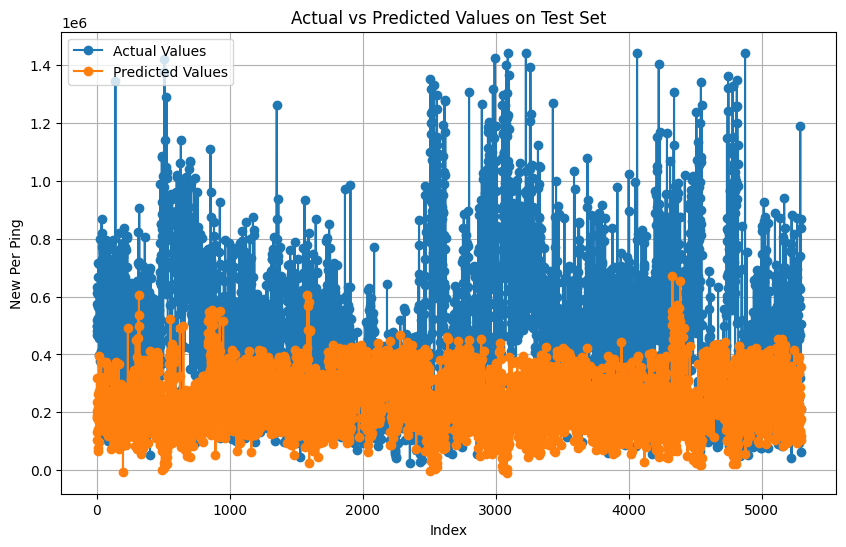

In [234]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_continuos_scaled, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

> 2 個 lightGBM

> df_main = onehot_591_df[['LightGBM_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y']]

Linear Regression MSE (Train): 8004551818.570621
Linear Regression RMSE (Train): 89468.16092091432
Linear Regression R² (Train): 0.7957155135956281
--------------------------------------------------
Linear Regression MSE (Test): 22670292739.11947
Linear Regression RMSE (Test): 150566.572449264
Linear Regression R² (Test): 0.5683999407511301


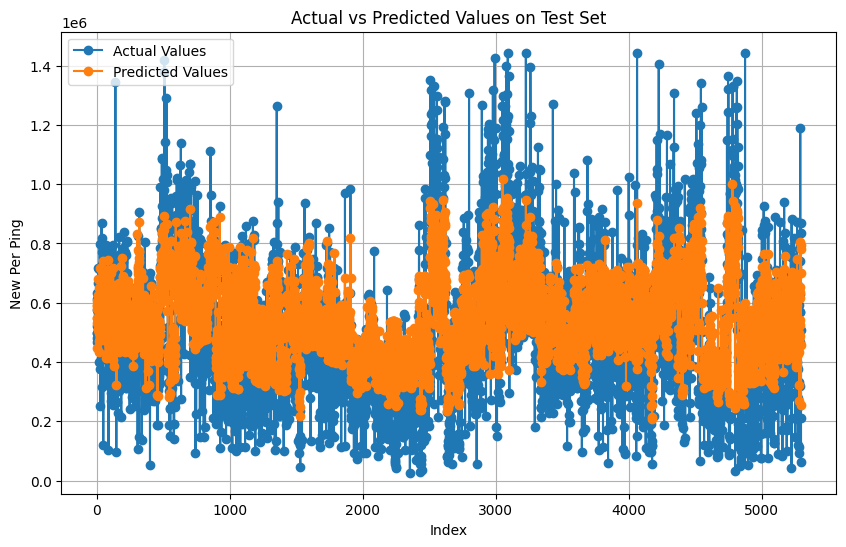

In [ ]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_continuos_scaled, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

> 3 個 lightGBM

> df_main = onehot_591_df[['LightGBM_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y','LightGBM_pred_y']]

Linear Regression MSE (Train): 8004549943.818871
Linear Regression RMSE (Train): 89468.15044371305
Linear Regression R² (Train): 0.7957155614412423
--------------------------------------------------
Linear Regression MSE (Test): 22667557004.302917
Linear Regression RMSE (Test): 150557.48737377
Linear Regression R² (Test): 0.5684520240357396


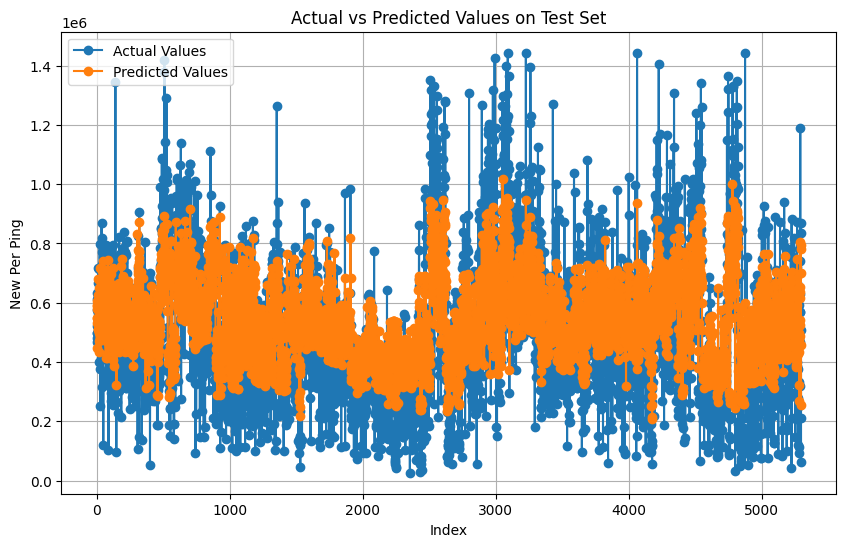

In [ ]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_continuos_scaled, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

> df_main = onehot_591_df[['XGBoost_pred_y','LightGBM_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y','LightGBM_pred_y']]

Linear Regression MSE (Train): 1871992943.0111816
Linear Regression RMSE (Train): 43266.53375313513
Linear Regression R² (Train): 0.9522247933946242
--------------------------------------------------
Linear Regression MSE (Test): 148265210882.09485
Linear Regression RMSE (Test): 385052.2183835523
Linear Regression R² (Test): -1.8226928755461578


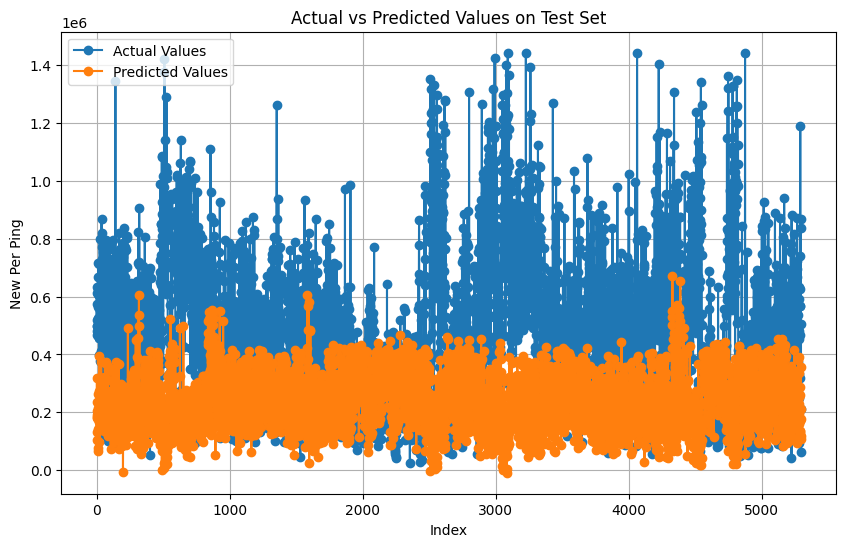

In [ ]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_continuos_scaled, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

> df_main = onehot_591_df[['CatBoost_pred_y', 'CatBoost_pred_y', 'LightGBM_pred_y','LightGBM_pred_y']]

Linear Regression MSE (Train): 8004550441.725492
Linear Regression RMSE (Train): 89468.15322630445
Linear Regression R² (Train): 0.7957155487341476
--------------------------------------------------
Linear Regression MSE (Test): 22664581483.01787
Linear Regression RMSE (Test): 150547.60537125083
Linear Regression R² (Test): 0.5685086724071435


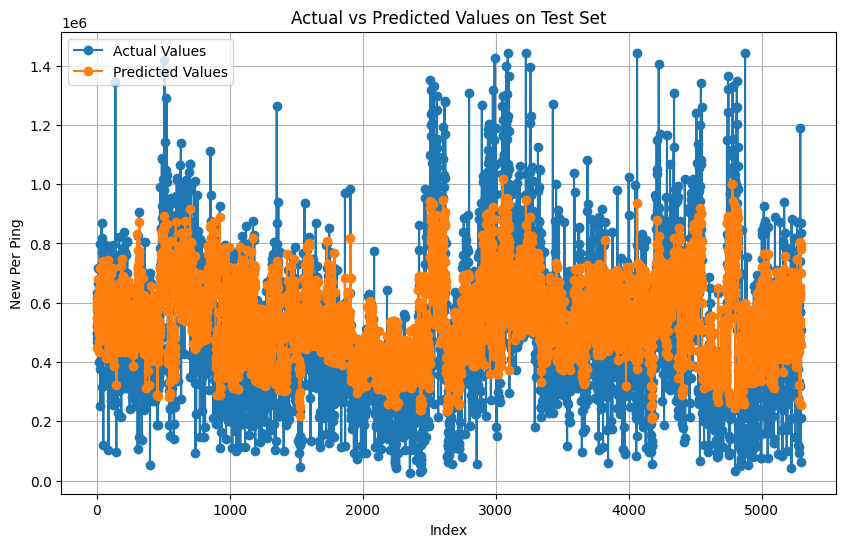

In [ ]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_continuos_scaled, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
linear_model.coef_

array([-7.61611346e+14, -3.64307685e+14, -1.16291832e+15, -1.21276677e+15,
       -8.73038234e+14, -5.83875455e+14, -7.63279519e+14, -6.96830813e+14,
       -9.21148597e+14, -5.15692292e+14, -8.40887080e+14, -5.73389528e+14,
       -9.52836969e+14, -2.39157295e+13, -7.49066865e+14, -5.33919400e+14,
       -7.79093905e+14, -1.63376519e+13, -8.74859012e+14, -1.19909813e+15,
       -1.27684009e+15, -6.53356292e+14, -1.37879729e+15, -1.09364251e+15,
       -7.43160915e+14, -8.14589078e+14, -1.10778622e+15, -5.39921133e+14,
       -1.42102157e+15, -2.81926225e+14, -1.63376519e+13, -2.66442834e+14,
       -4.66188660e+13, -6.44644868e+13, -6.78751986e+14, -2.32364543e+14,
       -8.18432274e+14, -8.05029512e+13, -2.20282963e+14, -6.47594716e+13,
       -6.53525354e+14,  1.33308086e+14,  1.33308086e+14, -2.46415000e+04,
        2.49406250e+05,  2.02472500e+04, -5.83960000e+04])

Feature Weights:
[-7.61120907e+14 -3.64073089e+14 -1.16216946e+15 -1.21198581e+15
 -8.72476043e+14 -5.83499469e+14 -7.62788006e+14 -6.96382090e+14
 -9.20555425e+14 -5.15360212e+14 -8.40345592e+14 -5.73020295e+14
 -9.52223391e+14 -2.39003290e+13 -7.48584504e+14 -5.33575584e+14
 -7.78592208e+14 -1.63271313e+13 -8.74295648e+14 -1.19832597e+15
 -1.27601787e+15 -6.52935564e+14 -1.37790942e+15 -1.09293826e+15
 -7.42682358e+14 -8.14064524e+14 -1.10707286e+15 -5.39573452e+14
 -1.42010650e+15 -2.81744679e+14 -1.63271313e+13 -2.66271258e+14
 -4.65888458e+13 -6.44229750e+13 -6.78314904e+14 -2.32214912e+14
 -8.17905246e+14 -8.04511114e+13 -2.20141112e+14 -6.47177698e+13
 -6.53104517e+14  1.33289997e+14  1.33289997e+14 -2.46410000e+04
  2.49406000e+05  2.02468750e+04 -5.83960000e+04]
Final Predicted Price on Test Set: [597128.69520575 547925.95959027 762296.75557291 ... 330502.33077442
 196171.92921076  58294.2181144 ]
Linear Regression MSE (Train): 75667875457.91339
Linear Regression RMSE (Train):

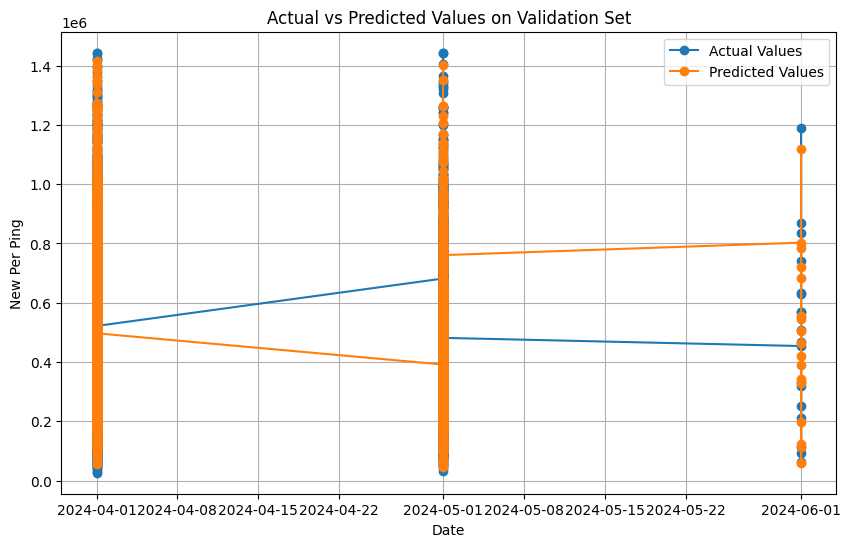

In [235]:
# 訓練線性回歸模型，使用初步預測值
linear_model = LinearRegression()
linear_model.fit(X_train_continuos_scaled, y_train)

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 計算特徵重要性（權重）
coefficients = linear_model.coef_

# 顯示特徵權重
print("Feature Weights:")
print(coefficients)

# 計算最終預測價格（加權）
print("Final Predicted Price on Test Set:", y_test_pred)

# 評估模型表現
# 計算均方誤差 (MSE)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# 計算均方根誤差 (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# 計算 R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 打印結果
print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Values', marker='o')
plt.plot(y_test.index, y_test_pred, label='Predicted Values', marker='o')
plt.xlabel('Date')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

## 算 MAE

Linear Regression MSE (Train): 1871993015.049171
Linear Regression MAE (Train): 28260.736602112218
Linear Regression RMSE (Train): 43266.534585626
Linear Regression R² (Train): 0.9522247915561398
--------------------------------------------------
Linear Regression MSE (Test): 148261988896.60852
Linear Regression MAE (Test): 302486.84602567914
Linear Regression RMSE (Test): 385048.03453154844
Linear Regression R² (Test): -1.8226315349563915


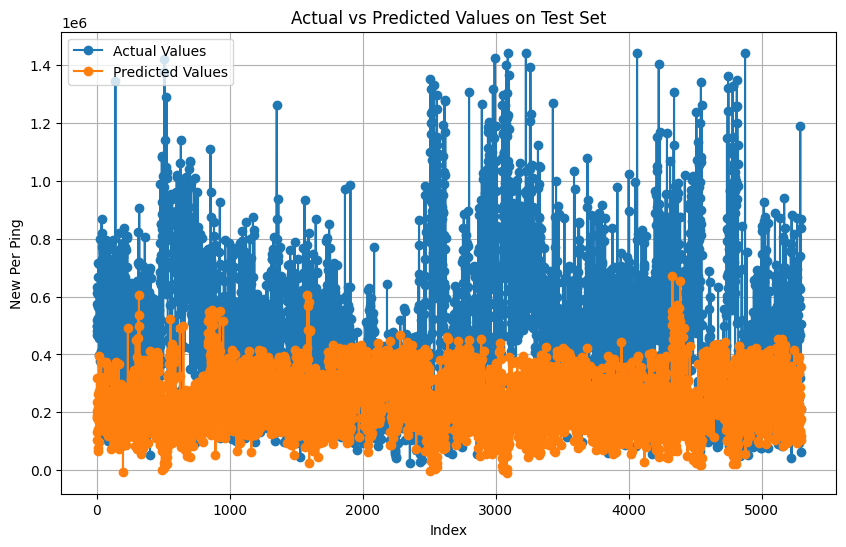

In [236]:
from sklearn.metrics import mean_absolute_error

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression MAE (Test): {mae_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression MSE (Train): 1871993015.049171
Linear Regression MAE (Train): 28260.736602112218
Linear Regression RMSE (Train): 43266.534585626
Linear Regression R² (Train): 0.9522247915561398
--------------------------------------------------
Linear Regression MSE (Test): 148261988896.60852
Linear Regression MAE (Test): 302486.84602567914
Linear Regression RMSE (Test): 385048.03453154844
Linear Regression R² (Test): -1.8226315349563915


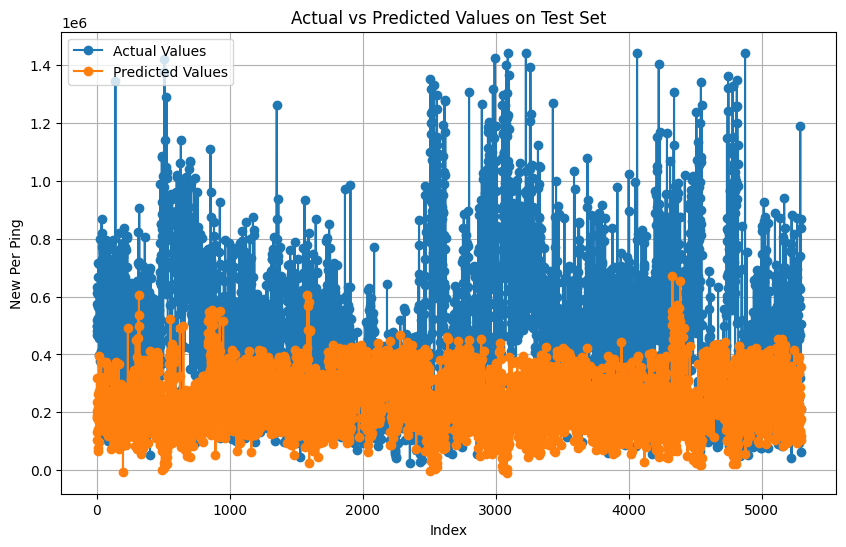

In [237]:
from sklearn.metrics import mean_absolute_error

# # 獲取訓練集和測試集的預測值
y_pred_train = linear_model.predict(X_train_continuos_scaled)
y_pred_test = linear_model.predict(X_test_continuos_scaled)

# 評估模型表現
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression MSE (Train): {mse_train}")
print(f"Linear Regression MAE (Train): {mae_train}")
print(f"Linear Regression RMSE (Train): {rmse_train}")
print(f"Linear Regression R² (Train): {r2_train}")
print("-" * 50)
print(f"Linear Regression MSE (Test): {mse_test}")
print(f"Linear Regression MAE (Test): {mae_test}")
print(f"Linear Regression RMSE (Test): {rmse_test}")
print(f"Linear Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o')
plt.plot(range(len(y_test)), y_pred_test, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# df_591 + XGBoost

In [ ]:
# XGBoost_bagging_model_training.pkl

In [ ]:
c591_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_fillna_final_version_one_hot_have_address_cor_full_near_fac_cols.csv')

In [ ]:
import joblib

# 載入之前保存的預測結果
train_preds_XGBoost = joblib.load("/content/drive/MyDrive/Colab Notebooks/2024_0710_bagging_model/XGBoost_bagging_model_training.pkl")

# X_train_final
main_train_XGBoost = train_preds_XGBoost.predict(X_train_final)

# X_test_final
main_test_XGBoost = train_preds_XGBoost.predict(X_test)

# 合併訓練集和測試集的預測結果
predict_y_XGBoost = list(main_train_XGBoost) + list(main_test_XGBoost)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


In [ ]:
len(predict_y_XGBoost)

669734

In [ ]:
len(c591_df)

51073

In [ ]:
c591_df.info(max_cols=173) # 0 3 4 5 14 15-130

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 173 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    total_price                           51073 non-null  int64  
 1    building_age                          51073 non-null  float64
 2    total_area_ping                       51073 non-null  float64
 3    address                               51073 non-null  object 
 4    latitude                              51073 non-null  float64
 5    longitude                             51073 non-null  float64
 6    community_name                        51073 non-null  int64  
 7    has_parking_space                     51073 non-null  int64  
 8    total_floors                          51073 non-null  float64
 9    transaction_floors                    51073 non-null  float64
 10   target_floors                         51073 non-null  float64
 11   

In [ ]:
df_merge_591 = c591_df.copy()

> 刪除不需要的欄位

- 0: 刪除 total_price 欄位。

- 3: 刪除 address 欄位。

- 4: 刪除 latitude 欄位。

- 5: 刪除 longitude 欄位。

- 14: 刪除 cor 欄位。

- 15-89: 前面有中文的 XXX_m。

In [ ]:
# 刪除指定的欄位
columns_to_drop = [df_merge_591.columns[i] for i in [0, 3, 4, 5] + list(range(14, 90))]
df_merge_591_drop = df_merge_591.drop(columns=columns_to_drop)

In [ ]:
df_merge_591_drop.info(max_cols=173)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 93 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   building_age                          51073 non-null  float64
 1   total_area_ping                       51073 non-null  float64
 2   community_name                        51073 non-null  int64  
 3   has_parking_space                     51073 non-null  int64  
 4   total_floors                          51073 non-null  float64
 5   transaction_floors                    51073 non-null  float64
 6   target_floors                         51073 non-null  float64
 7   bedrooms                              51073 non-null  float64
 8   living_rooms                          51073 non-null  float64
 9   bathrooms                             51073 non-null  float64
 10  elevator_available                    51073 non-null  int64  
 11  main_building_r

> 合併 經濟指標表

In [ ]:
economic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_eco_df_to_11306_fillna_v2.csv')

In [ ]:
df_merge_591_drop['year_month_for_combine'] = '2024-06-01'
df_merge_591_drop['year_month_for_combine'] = pd.to_datetime(df_merge_591_drop['year_month_for_combine']).dt.to_period('M')

In [ ]:
# economic_df 中的 year_month_for_combine 是 object 類型
# 確保日期欄位轉換為日期格式
economic_df['year_month_for_combine'] = pd.to_datetime(economic_df['year_month_for_combine']).dt.to_period('M')

In [ ]:
# 合併兩個 DataFrame
df_eco_591 = df_merge_591_drop.merge(economic_df, on='year_month_for_combine', how='inner')
df_eco_591.drop('date', axis=1, inplace=True)

In [ ]:
# 重新命名欄位
df_eco_591.rename(columns={'target_floors': 'target_floor'}, inplace=True)

In [ ]:
# 重新索引
df_eco_591_reindexed = df_eco_591.reindex(df.columns, axis=1)
len(df_eco_591_reindexed.columns)

119

In [ ]:
df_eco_591_reindexed.info(max_cols=120)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 119 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    community_name                        51073 non-null  int64  
 1    main_building_ratio                   51073 non-null  float64
 2    building_age                          51073 non-null  float64
 3    total_area_ping                       51073 non-null  float64
 4    total_floors                          51073 non-null  float64
 5    target_floor                          51073 non-null  float64
 6    transaction_floors                    51073 non-null  float64
 7    bedrooms                              51073 non-null  float64
 8    living_rooms                          51073 non-null  float64
 9    bathrooms                             51073 non-null  float64
 10   new_per_ping                          51073 non-null  float64
 11   

> 對三個新北市行政區補 0

In [ ]:
df_eco_591_reindexed.isnull().sum().sum()

153219

In [ ]:
df_eco_591_reindexed = df_eco_591_reindexed.fillna(0)

> 全部設為測試集

In [ ]:
# 設置成驗證集
X_test_XGB = df_eco_591_reindexed.drop(['new_per_ping'], axis=1)
y_test_XGB = df_eco_591_reindexed['new_per_ping']

> 標準化 / 正則化

> 取出 one-hot encoding 的欄位， 再對剩餘欄位標準化

> 第 0 列, 第 47-96 列 是 one-hot encoding

In [ ]:
# # 將資料框保存為 CSV 文件
# df_eco_591_reindexed.to_csv('df_eco_591_reindexed.csv', index=False)

# # 下載 CSV 文件
# from google.colab import files
# files.download('df_eco_591_reindexed.csv')

In [ ]:
# 確定 one-hot encoding 的欄位範圍
one_hot_cols = list(range(46, 96)) + [0]

# 取出 one-hot encoding 的欄位
X_test_XGB_one_hot = X_test_XGB.iloc[:, one_hot_cols]

# 檢查連續變數列是否存在於 X_train 中
print("Columns in X_train:", X_test_XGB.columns)
print("One-hot columns:", X_test_XGB_one_hot.columns)

Columns in X_train: Index(['community_name', 'main_building_ratio', 'building_age',
       'total_area_ping', 'total_floors', 'target_floor', 'transaction_floors',
       'bedrooms', 'living_rooms', 'bathrooms',
       ...
       'NE0206', 'PA0120', 'PA1205', 'PE0503', 'TSE收盤', '水泥(TSE11)收盤',
       '建材營造(TSE25)收盤', '航運業(TSE26)收盤', '鋼鐵(TSE20)收盤', '預拌混凝土3000磅台北'],
      dtype='object', length=118)
One-hot columns: Index(['elevator_available', 'property_type__公寓', 'property_type__透天厝',
       'property_type__電梯大樓', 'city__台北市', 'city__新北市', 'district__三峽區',
       'district__三芝區', 'district__三重區', 'district__中和區', 'district__中山區',
       'district__中正區', 'district__五股區', 'district__信義區', 'district__內湖區',
       'district__八里區', 'district__北投區', 'district__南港區', 'district__土城區',
       'district__坪林區', 'district__士林區', 'district__大同區', 'district__大安區',
       'district__平溪區', 'district__文山區', 'district__新店區', 'district__新莊區',
       'district__松山區', 'district__板橋區', 'district__林口區', 'dist

In [ ]:
# 取出非 one-hot encoding 的欄位，即連續型變數，並排除日期欄位
continuos_col_name = X_test_XGB.drop(columns=X_test_XGB_one_hot.columns).select_dtypes(include=['number']).columns
print("Continuous columns before selection:", continuos_col_name)

Continuous columns before selection: Index(['main_building_ratio', 'building_age', 'total_area_ping',
       'total_floors', 'target_floor', 'transaction_floors', 'bedrooms',
       'living_rooms', 'bathrooms', 'Public_Activity_Space_under_250_m',
       'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
       'School_under_250_m', 'Kindergarten_under_250_m',
       'Convenience_Store_under_250_m', 'Bank_under_250_m',
       'Clinic_under_250_m', 'Pharmacy_under_250_m',
       'acc_Public_Activity_Space_under_500m',
       'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
       'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
       'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
       'acc_School_under_500m', 'acc_School_under_750m',
       'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
       'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
       'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
    

In [ ]:
X_test_XGB_continuos = X_test_XGB[continuos_col_name]

# 確認連續變數是否正確被選擇
print("Continuous columns:", continuos_col_name)
print("X_test_XGB_continuos shape:", X_test_XGB_continuos.shape)
print("X_test_XGB_continuos head:\n", X_test_XGB_continuos.head())

Continuous columns: Index(['main_building_ratio', 'building_age', 'total_area_ping',
       'total_floors', 'target_floor', 'transaction_floors', 'bedrooms',
       'living_rooms', 'bathrooms', 'Public_Activity_Space_under_250_m',
       'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
       'School_under_250_m', 'Kindergarten_under_250_m',
       'Convenience_Store_under_250_m', 'Bank_under_250_m',
       'Clinic_under_250_m', 'Pharmacy_under_250_m',
       'acc_Public_Activity_Space_under_500m',
       'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
       'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
       'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
       'acc_School_under_500m', 'acc_School_under_750m',
       'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
       'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
       'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
       'acc_Daycare_C

In [ ]:
# 創建標準化器並在 X_test_XGB_continuos 上擬合
scaler = StandardScaler()
X_test_XGB_continuos_scaled = scaler.fit_transform(X_test_XGB_continuos)

# 使用標準化器轉換 X_test_XGB_continuos
X_test_XGB_continuos_scaled = scaler.transform(X_test_XGB_continuos)

# 合併標準化後的連續型變數與 one-hot encoding 的欄位
X_test_XGB = np.hstack([X_test_XGB_continuos_scaled, X_test_XGB_one_hot])

> 開始訓練模型

In [ ]:
import joblib

# 載入之前保存的預測結果
train_preds_XGBoost = joblib.load("/content/drive/MyDrive/Colab Notebooks/2024_0710_bagging_model/XGBoost_bagging_model_training.pkl")

# X_test_XGB
main_test_XGBoost = train_preds_XGBoost.predict(X_test_XGB)

# 合併訓練集和測試集的預測結果
predict_y_XGBoost = list(main_test_XGBoost)

In [ ]:
X_test_XGB.shape

(51073, 118)

In [ ]:
main_test_XGBoost.shape

(51073,)

In [ ]:
# 確保預測值與 df_merge_591 的索引對齊
df_merge_591['XGBoost_pred_y'] = pd.Series(predict_y_XGBoost, index=df_merge_591.index[:len(predict_y_XGBoost)])

# 顯示更新後
df_merge_591.head()

,total_price,building_age,total_area_ping,address,latitude,longitude,community_name,has_parking_space,total_floors,transaction_floors,...,district__石門區,district__萬華區,district__萬里區,district__蘆洲區,district__貢寮區,district__金山區,district__鶯歌區,usage_category__住商用,usage_category__住家用,XGBoost_pred_y
0,115000000,66.0,51.96,台北市南港區中南街,25.053310,121.616095,0,0,2.0,2.0,...,0,0,0,0,0,0,0,0,1,334632.81250
1,29880000,46.0,33.95,台北市松山區民生東路五段36巷,25.024869,121.545711,0,0,4.0,1.0,...,0,0,0,0,0,0,0,0,1,620302.06250
2,13200000,30.0,14.47,台北市內湖區成功路四段61巷,25.082335,121.594414,1,0,9.0,1.0,...,0,0,0,0,0,0,0,0,1,476745.00000
3,24800000,45.0,31.26,台北市文山區羅斯福路五段170巷3弄1號,25.003667,121.537338,1,0,5.0,1.0,...,0,0,0,0,0,0,0,0,1,356149.65625
4,29800000,38.0,35.72,台北市信義區松山路482巷,25.038466,121.577002,1,0,14.0,1.0,...,0,0,0,0,0,0,0,0,1,480713.09375


In [ ]:
df_merge_591.info(max_cols=174)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 174 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    total_price                           51073 non-null  int64  
 1    building_age                          51073 non-null  float64
 2    total_area_ping                       51073 non-null  float64
 3    address                               51073 non-null  object 
 4    latitude                              51073 non-null  float64
 5    longitude                             51073 non-null  float64
 6    community_name                        51073 non-null  int64  
 7    has_parking_space                     51073 non-null  int64  
 8    total_floors                          51073 non-null  float64
 9    transaction_floors                    51073 non-null  float64
 10   target_floors                         51073 non-null  float64
 11   

In [ ]:
# # 將資料框保存為 CSV 文件
# df_merge_591.to_csv('df_merge_591.csv', index=False)

# # 下載 CSV 文件
# from google.colab import files
# files.download('df_merge_591.csv')

> df_new_merge_591

> 需要切比鄰


In [ ]:
# c591_final_versoin_0711

In [ ]:
new_c591_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/c591_final_versoin_0711.csv')

> 刪除不需要的欄位

- 0: 刪除 total_price 欄位。

- 3: 刪除 address 欄位。

- 4: 刪除 property_type 欄位。

- 5: 刪除 usage_category 欄位。

- 6: 刪除 latitude 欄位。

- 7: 刪除 longitude 欄位。

- 16: 刪除 city 欄位。

- 17: 刪除 district 欄位。

- 18: 刪除 cor 欄位。

- 19-93: 前面有中文的 XXX_m。


In [ ]:
df_merge_new_591 = new_c591_df.copy()

In [ ]:
# 刪除指定的欄位
columns_to_drop = [df_merge_new_591.columns[i] for i in [0, 3, 4, 5, 6, 7] + list(range(16, 94))]
df_merge_new_591_drop = df_merge_new_591.drop(columns=columns_to_drop)

In [ ]:
df_merge_new_591_drop.info(max_cols=173)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 93 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   building_age                          51073 non-null  float64
 1   total_area_ping                       51073 non-null  float64
 2   community_name                        51073 non-null  int64  
 3   has_parking_space                     51073 non-null  int64  
 4   total_floors                          51073 non-null  float64
 5   transaction_floors                    51073 non-null  float64
 6   target_floors                         51073 non-null  float64
 7   bedrooms                              51073 non-null  float64
 8   living_rooms                          51073 non-null  float64
 9   bathrooms                             51073 non-null  float64
 10  elevator_available                    51073 non-null  int64  
 11  main_building_r

In [ ]:
df_merge_new_591_drop['year_month_for_combine'] = '2024-06-01'
df_merge_new_591_drop['year_month_for_combine'] = pd.to_datetime(df_merge_new_591_drop['year_month_for_combine']).dt.to_period('M')

# # economic_df 中的 year_month_for_combine 是 object 類型
# # 確保日期欄位轉換為日期格式
# economic_df['year_month_for_combine'] = pd.to_datetime(economic_df['year_month_for_combine']).dt.to_period('M')

# 合併兩個 DataFrame
df_eco_new_591 = df_merge_new_591_drop.merge(economic_df, on='year_month_for_combine', how='inner')
df_eco_new_591.drop('date', axis=1, inplace=True)

# 重新命名欄位
df_eco_new_591.rename(columns={'target_floors': 'target_floor'}, inplace=True)

# 重新索引
df_eco_new_591_reindexed = df_eco_new_591.reindex(df.columns, axis=1)
len(df_eco_new_591_reindexed.columns)

119

In [ ]:
df_eco_new_591_reindexed.info(max_cols=178)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 119 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    community_name                        51073 non-null  int64  
 1    main_building_ratio                   51073 non-null  float64
 2    building_age                          51073 non-null  float64
 3    total_area_ping                       51073 non-null  float64
 4    total_floors                          51073 non-null  float64
 5    target_floor                          51073 non-null  float64
 6    transaction_floors                    51073 non-null  float64
 7    bedrooms                              51073 non-null  float64
 8    living_rooms                          51073 non-null  float64
 9    bathrooms                             51073 non-null  float64
 10   new_per_ping                          51073 non-null  float64
 11   

In [ ]:
df_eco_new_591_reindexed.isnull().sum().sum()

153219

In [ ]:
df_eco_new_591_reindexed = df_eco_new_591_reindexed.fillna(0)

In [ ]:
# 設置成驗證集
X_test_XGB = df_eco_new_591_reindexed.drop(['new_per_ping'], axis=1)
y_test_XGB = df_eco_new_591_reindexed['new_per_ping']

In [ ]:
# # 將資料框保存為 CSV 文件
# df_eco_new_591_reindexed.to_csv('df_eco_new_591_reindexed.csv', index=False)

# # 下載 CSV 文件
# from google.colab import files
# files.download('df_eco_new_591_reindexed.csv')

> 標準化 / 正則化

> 取出 one-hot encoding 的欄位， 再對剩餘欄位標準化

> 第 0 列, 第 47-96 列 是 one-hot encoding

In [ ]:
# 確定 one-hot encoding 的欄位範圍
one_hot_cols = list(range(46, 96)) + [0]

# 取出 one-hot encoding 的欄位
X_test_XGB_one_hot = X_test_XGB.iloc[:, one_hot_cols]

# 檢查連續變數列是否存在於 X_train 中
print("Columns in X_train:", X_test_XGB.columns)
print("One-hot columns:", X_test_XGB_one_hot.columns)

Columns in X_train: Index(['community_name', 'main_building_ratio', 'building_age',
       'total_area_ping', 'total_floors', 'target_floor', 'transaction_floors',
       'bedrooms', 'living_rooms', 'bathrooms',
       ...
       'NE0206', 'PA0120', 'PA1205', 'PE0503', 'TSE收盤', '水泥(TSE11)收盤',
       '建材營造(TSE25)收盤', '航運業(TSE26)收盤', '鋼鐵(TSE20)收盤', '預拌混凝土3000磅台北'],
      dtype='object', length=118)
One-hot columns: Index(['elevator_available', 'property_type__公寓', 'property_type__透天厝',
       'property_type__電梯大樓', 'city__台北市', 'city__新北市', 'district__三峽區',
       'district__三芝區', 'district__三重區', 'district__中和區', 'district__中山區',
       'district__中正區', 'district__五股區', 'district__信義區', 'district__內湖區',
       'district__八里區', 'district__北投區', 'district__南港區', 'district__土城區',
       'district__坪林區', 'district__士林區', 'district__大同區', 'district__大安區',
       'district__平溪區', 'district__文山區', 'district__新店區', 'district__新莊區',
       'district__松山區', 'district__板橋區', 'district__林口區', 'dist

In [ ]:
# 取出非 one-hot encoding 的欄位，即連續型變數，並排除日期欄位
continuos_col_name = X_test_XGB.drop(columns=X_test_XGB_one_hot.columns).select_dtypes(include=['number']).columns
print("Continuous columns before selection:", continuos_col_name)

Continuous columns before selection: Index(['main_building_ratio', 'building_age', 'total_area_ping',
       'total_floors', 'target_floor', 'transaction_floors', 'bedrooms',
       'living_rooms', 'bathrooms', 'Public_Activity_Space_under_250_m',
       'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
       'School_under_250_m', 'Kindergarten_under_250_m',
       'Convenience_Store_under_250_m', 'Bank_under_250_m',
       'Clinic_under_250_m', 'Pharmacy_under_250_m',
       'acc_Public_Activity_Space_under_500m',
       'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
       'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
       'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
       'acc_School_under_500m', 'acc_School_under_750m',
       'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
       'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
       'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
    

In [ ]:
X_test_XGB_continuos = X_test_XGB[continuos_col_name]

# 確認連續變數是否正確被選擇
print("Continuous columns:", continuos_col_name)
print("X_test_XGB_continuos shape:", X_test_XGB_continuos.shape)
print("X_test_XGB_continuos head:\n", X_test_XGB_continuos.head())

Continuous columns: Index(['main_building_ratio', 'building_age', 'total_area_ping',
       'total_floors', 'target_floor', 'transaction_floors', 'bedrooms',
       'living_rooms', 'bathrooms', 'Public_Activity_Space_under_250_m',
       'MRT_Exit_under_250_m', 'Religious_Site_under_250_m',
       'School_under_250_m', 'Kindergarten_under_250_m',
       'Convenience_Store_under_250_m', 'Bank_under_250_m',
       'Clinic_under_250_m', 'Pharmacy_under_250_m',
       'acc_Public_Activity_Space_under_500m',
       'acc_Public_Activity_Space_under_750m', 'acc_MRT_Exit_under_500m',
       'acc_MRT_Exit_under_750m', 'acc_Religious_Site_under_500m',
       'acc_Religious_Site_under_750m', 'acc_Shopping_Area_under_750m',
       'acc_School_under_500m', 'acc_School_under_750m',
       'acc_Hospital_under_500m', 'acc_Hospital_under_750m',
       'acc_Gas_Station_under_750m', 'acc_Kindergarten_under_500m',
       'acc_Kindergarten_under_750m', 'acc_Daycare_Center_under_500m',
       'acc_Daycare_C

In [ ]:
# 創建標準化器並在 X_test_XGB_continuos 上擬合
scaler = StandardScaler()
X_test_XGB_continuos_scaled = scaler.fit_transform(X_test_XGB_continuos)

# 使用標準化器轉換 X_test_XGB_continuos
X_test_XGB_continuos_scaled = scaler.transform(X_test_XGB_continuos)

# 合併標準化後的連續型變數與 one-hot encoding 的欄位
X_test_XGB = np.hstack([X_test_XGB_continuos_scaled, X_test_XGB_one_hot])

In [ ]:
import joblib

# 載入之前保存的預測結果
train_preds_XGBoost = joblib.load("/content/drive/MyDrive/Colab Notebooks/2024_0710_bagging_model/XGBoost_bagging_model_training.pkl")

# X_test_XGB
main_test_XGBoost = train_preds_XGBoost.predict(X_test_XGB)

# 合併訓練集和測試集的預測結果
predict_y_XGBoost = list(main_test_XGBoost)

In [ ]:
X_test_XGB.shape

(51073, 118)

In [ ]:
main_test_XGBoost.shape

(51073,)

In [ ]:
# 確保預測值與 df_merge_591 的索引對齊
df_merge_new_591['XGBoost_pred_y'] = pd.Series(predict_y_XGBoost, index=df_merge_new_591.index[:len(predict_y_XGBoost)])

In [ ]:
# 顯示更新後
df_merge_new_591.info(max_cols=178)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51073 entries, 0 to 51072
Data columns (total 178 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    total_price                           51073 non-null  int64  
 1    building_age                          51073 non-null  float64
 2    total_area_ping                       51073 non-null  float64
 3    address                               51073 non-null  object 
 4    property_type                         51073 non-null  object 
 5    usage_category                        51073 non-null  object 
 6    latitude                              51073 non-null  float64
 7    longitude                             51073 non-null  float64
 8    community_name                        51073 non-null  int64  
 9    has_parking_space                     51073 non-null  int64  
 10   total_floors                          51073 non-null  float64
 11   

In [ ]:
# # 將資料框保存為 CSV 文件
# df_merge_new_591.to_csv('df_merge_new_591.csv', index=False)

# # 下載 CSV 文件
# from google.colab import files
# files.download('df_merge_new_591.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

XGBoost
--------------------------------------------------
XGBoost Regression MSE (Test): 151016201578.54553
XGBoost Regression MAE (Test): 277762.179370258
XGBoost Regression RMSE (Test): 388608.030769496
XGBoost Regression R² (Test): -0.3373004557145205


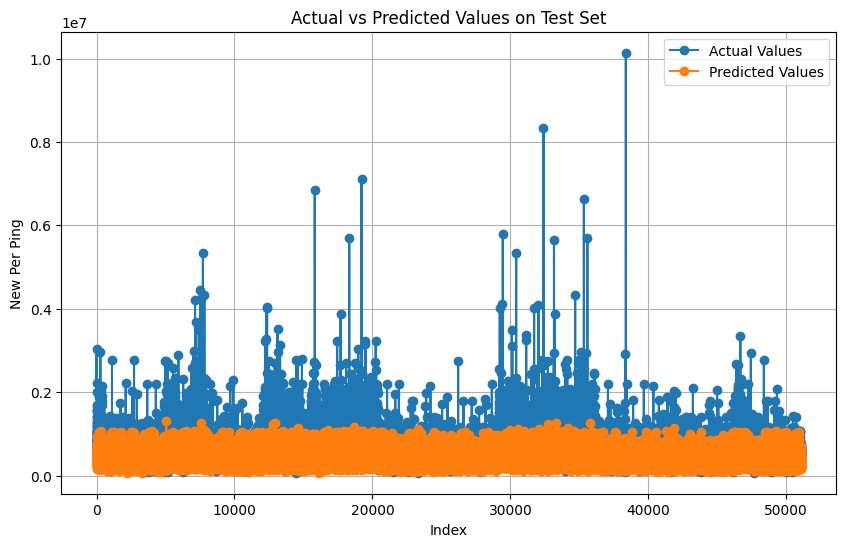

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 獲取訓練集和測試集的預測值
# predict_y_XGBoost

# 評估模型表現
mse_test = mean_squared_error(y_test_XGB, predict_y_XGBoost)

mae_test = mean_absolute_error(y_test_XGB, predict_y_XGBoost)

rmse_test = np.sqrt(mse_test)

r2_test = r2_score(y_test_XGB, predict_y_XGBoost)

print("XGBoost")
print("-" * 50)
print(f"XGBoost Regression MSE (Test): {mse_test}")
print(f"XGBoost Regression MAE (Test): {mae_test}")
print(f"XGBoost Regression RMSE (Test): {rmse_test}")
print(f"XGBoost Regression R² (Test): {r2_test}")
print("=" * 50)

# 繪製實際值與預測值的比較圖
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_XGB)), y_test_XGB, label='Actual Values', marker='o')
plt.plot(range(len(y_test_XGB)), predict_y_XGBoost, label='Predicted Values', marker='o')
plt.xlabel('Index')
plt.ylabel('New Per Ping')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

```
# Evaluating XGBoost with Bagging Regressor
--------------------------------------------------
XGBoost Bagging Regressor Mean MSE (Train): 2282459157.0882735
XGBoost Bagging Regressor RMSE (Train): 47775.08929440398
XGBoost Bagging Regressor Mean R² (Train): 0.9417492687644321
--------------------------------------------------
XGBoost Bagging Regressor Mean MSE (Test): 151016201578.54553
XGBoost Bagging Regressor RMSE (Test): 388608.030769496
XGBoost Bagging Regressor Mean R² (Test): -0.3373004557145205
--------------------------------------------------
XGBoost Bagging Regressor 模型已保存為 XGBoost_bagging_model_training_240710_1642.pkl
==================================================
```



In [ ]:
# 將資料框保存為 CSV 文件
new_c591_df.to_csv('new_591_df.csv', index=False)

# 下載 CSV 文件
from google.colab import files
files.download('new_591_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>